# Japan : a Visualization Study  
  ### Simone Luzi 782201
**In this notebook, you will find the sources, methods, and charts related to a data visualization study on inbound tourism in Japan. All the procedures used to collect, reorganize, process, and ultimately visualize the data presented are detailed here.**  
  
  *Please note that while some of the data comes from official sources, certain data points were manually collected by the project developer; therefore, caution is advised when assessing the absolute accuracy of the information provided*
<a id="intro"></a>  

INDEX:  
  1. [Incoming Tourism](#incoming_tourism)
  2. [Exchange rates](#exchange_rates)  
  3. [Places of Interest](#ploi)
  4. [Holidays](#holidays)  
  5. [UNESCO Sites](#unesco)
  6. [Biodiversity](#Biodiversity)  
  7. [Japanese Dishes](#japanese_dishes)
  8. [Public Opinion](#public_opinion)

In [115]:
import pandas as pd
import numpy as np
import os
import re 
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import fitz
from PIL import Image
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import networkx as nx
import emoji
import deepl



In [116]:
#Generic Data Folder
data_folder= 'Data'

# Specific Data Folders
touristic_folder = "Touristic International Arrivals"
exchange_rates_folder = 'Exchange rates'
ploi_folder = 'Places of Interest'
holidays_folder = 'Japan Holidays'
biodiversity_folder = 'Biodiversity'
unesco_folder = 'UNESCO Sites'
cuisine_folder = 'Cuisines'
comment_folder = 'Comments'

# More Specific Data Folders
arrivals_folder = 'Arrivals' #for arrivals data in touristic data folder
dishes_folder = 'Japanese Dishes' #for dishes data in cousine data folder

### Incoming Tourism
  <a id="incoming_tourism"></a>
  For this section, data has been sourced and collected from the [Japan Tourism Statistic](https://statistics.jnto.go.jp/en/) website in both .csv, .pdf and .jpeg format. The download requires filling out a specific form before downloading.
  
  [_click here to get back to the top_](#intro) 

**Arrivals**  
  
  The data is provided in PDF format, with each document containing information on the number of visitor arrivals in a specific year. This information must be extracted from each PDF and then converted into a usable dataframe using fitz (PyMuPDF)

In [117]:
# File names for arrivals data
fnames_arr= os.listdir(os.path.join(data_folder,touristic_folder,arrivals_folder))

In [118]:
# The for loop below is used to read the text from the pdf files, organize and process data in a compatible way, 
# and store it in a dataframe
dfs=[]
for file in fnames_arr:
    file_path = os.path.join(data_folder, touristic_folder, arrivals_folder, file)
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue
    
    try:
        doc = fitz.open(file_path)
        text = ""
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text += page.get_text("text")
        lines = text.split('\n')
        data = [line.split(',') for line in lines]

        def parse_full_data_C_A(lines, first_row, last_row):
            country_area = []
            area = []
            for i in range(first_row, last_row + 1):
                if i % 2 == 0:
                    country_area.append(lines[i].strip())
                else:
                    area.append(lines[i].strip())

            return country_area, area

        def parse_full_data_V_R(lines, first_row, last_row):
            visitor_arrivals = []
            rate = []
            for i in range(first_row, last_row + 1):
                if i % 2 == 0:
                    visitor_arrivals.append(lines[i].strip())
                else:
                    rate.append(lines[i].strip())

            return visitor_arrivals, rate

        country_area, area = parse_full_data_C_A(lines, 4, 51)
        visitor_arrivals, rate = parse_full_data_V_R(lines, 53, 100)

        if len(country_area) == len(area) & len(visitor_arrivals) == len(rate) & len(country_area) == len(visitor_arrivals):
            df = pd.DataFrame({"Country/Area": country_area,
                    "Continent": area,
                    "Visitor Arrivals" : visitor_arrivals,
                    "Rate(％)" : rate,
                    "Year": int(re.search(r"\d{4}", file).group(0))})
        else:
            raise ValueError("The number of entries do not match")

        dfs.append(df)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue 

def remove_dots(value):
    return re.sub(r'\.', '', value)

# Dictionary to adjust country names in data
country_adjustment={"Middle East": "Israel, Turkey, Saudi Arabia, UAE, Bahrain, Oman, Qatar and Kuwait",
                    "Nordic Countries":"Sweden, Norway, Denmark and Finland"}

# Dictionary to adjust continents in data
continent_adjustment={'Australia': "Oceania", 
                    'Canada': "America", 
                    'China':"Asia", 
                    'France':"Europe", 
                    'Germany':"Europe",
                    'Hong Kong':"Asia",
                    'India':"Asia",
                    'Indonesia':"Asia", 
                    'Italy':"Asia", 
                    'Malaysia':"Asia", 
                    'Mexico':"America", 
                    'Israel, Turkey, Saudi Arabia, UAE, Bahrain, Oman, Qatar and Kuwait':"Europe & Asia",
                    'Sweden, Norway, Denmark and Finland':"Europe", 
                    'Others':"Other", 
                    'Philippines':"Asia", 
                    'Russia':"Europe & Asia", 
                    'Singapore':"Asia",
                    'South Korea':"Asia", 
                    'Spain':"Europe", 
                    'Taiwan':"Asia", 
                    'Thailand':"Asia", 
                    'United Kingdom':"Europe",
                    'United States':"America", 
                    'Vietnam':"Asia"}

# Creation of the dataframe
if dfs:
    arrivals_df = pd.concat(dfs, ignore_index=True)
    arrivals_df.sort_values(by=["Year", "Country/Area"], inplace=True)
    arrivals_df['Rate(％)'] = arrivals_df['Rate(％)'].astype(str).str.replace(',', '.', regex=True).astype(float)
    arrivals_df['Visitor Arrivals'] = arrivals_df['Visitor Arrivals'].astype(str).apply(remove_dots).astype(int)
    arrivals_df["Country/Area"] = arrivals_df["Country/Area"].replace(country_adjustment)
    arrivals_df["Continent"] = arrivals_df["Country/Area"].map(continent_adjustment)
else:
    print("No data frames to concatenate.")

In [119]:
# Continent color definition
continent_colors = {'Asia':'#d62728', 
                    'America':'#2ca02c', 
                    'Europe':'#bcbd22', 
                    'Europe & Asia':'#ff7f0e',
                    'Africa':'#7b02ab', 
                    'Oceania': '#1f77b4',
                    'Other': '#e377c2'}

In [120]:
#Graph 1: Total Annual Visitor Arrivals per Continent
fig_bar = px.bar(arrivals_df.groupby(['Year',"Continent"])['Visitor Arrivals'].sum().reset_index(), x='Year', y='Visitor Arrivals', color="Continent", color_discrete_map=continent_colors, title='Total Annual Visitor Arrivals per Continent')
fig_bar.show()

In [121]:
#Graph 2: Arrivals per Country over time
def update_graph(country, fig): # Function to create and update the graph based on the selected country
    filtered_df = arrivals_df[arrivals_df['Country/Area'] == country]
    
    yearly_visitors = filtered_df.groupby('Year')['Visitor Arrivals'].sum().reset_index()
    
    with fig.batch_update():
        if fig.data:
            fig.data[0].x = yearly_visitors['Year']
            fig.data[0].y = yearly_visitors['Visitor Arrivals']
        else:
            fig.add_trace(go.Scatter(
                x=yearly_visitors['Year'],
                y=yearly_visitors['Visitor Arrivals'],
                mode='lines',
                name=country))
        fig.update_layout(title=f'Visitor Arrivals by Year for {country}',
                          xaxis_title='Year',
                          yaxis_title='Visitor Arrivals')

# Create the dropdown widget
country_selector = widgets.Dropdown(options=arrivals_df['Country/Area'].unique(),
    description='Country:',
    value=arrivals_df['Country/Area'].unique()[0])

# Create and display the figure 
fig = go.FigureWidget()
update_graph(country_selector.value, fig)

widgets.interactive(update_graph, country=country_selector, fig=widgets.fixed(fig))
display(widgets.VBox([country_selector, fig]))

**Arrivals per month**    

  Data is provided in CSV format, directly downloadable from the [source website](https://statistics.jnto.go.jp/en/).

In [122]:
# File name for Arrivals per month
filename_arpm="Arrivals per month.csv"

In [123]:
# Import data.'utf-16' Encoding is necesary for the correct read of the file
arpm_df = pd.read_csv(os.path.join(data_folder, touristic_folder, filename_arpm), sep="\t", header=0, encoding='utf-16')

In [124]:
# arpm_df needs to be reorganized since it is in an uncomfortable format for time plots
growth_rate=[]
visitor_pm=[]
for i in arpm_df.columns:
    for j in arpm_df[i]:
        if ".1" in i:
            growth_rate.append(j)
        else:
            visitor_pm.append(j)

arpm_df=pd.DataFrame({"Visitor Arrivals":visitor_pm, "Growth Rate (1 year %)":growth_rate})
arpm_df=arpm_df[~arpm_df.apply(lambda row: row.astype(str).str.contains('Visitor Arrivals')).any(axis=1)]
arpm_dates=[pd.to_datetime(f"{str(month).zfill(2)}-{year}").strftime('%Y-%m') for month in range(1, 13) for year in range(2000, 2025)]
arpm_df.insert(0, 'Date', arpm_dates)
arpm_df.sort_values(by='Date', ignore_index=True, inplace=True)

In [125]:
# Adjustment of data types and formats
def convert_date(date):
    if pd.isna(date):
        return None
    return pd.to_datetime(date, format='%Y-%m')

def remove_dots(value):
    if pd.isna(value):
        return None
    return int(value.replace('.', ''))

def adjust_floats(value):
    if pd.isna(value):
        return None
    return float(value.replace('.', '').replace(',', '.'))

arpm_df['Date'] = arpm_df['Date'].apply(convert_date)
arpm_df['Visitor Arrivals'] = arpm_df['Visitor Arrivals'].apply(remove_dots)
arpm_df['Growth Rate (1 year %)'] = arpm_df['Growth Rate (1 year %)'].apply(adjust_floats)
arpm_df["Growth Rate (1 month %)"] = arpm_df['Visitor Arrivals'].ffill().pct_change() * 100 # Calculation of the monthly growth rate

In [126]:
#Graph 3: Number of Visitors per Month
fig = px.line(arpm_df.reset_index(), x='Date', y='Visitor Arrivals', title='Number of Visitors per Month')
fig.show()

In [127]:
# Graph 4: Growth Rate per Month
def plot_growth_rate(rate_type, fig): # Function to create and update the graph depending on the selected rate
    if rate_type == 'Month':
        growth_data = arpm_df['Growth Rate (1 month %)']
        title = 'Visitors Growth Rate per month'
        ylabel = 'Growth Rate (1 month %)'
    else:
        growth_data = arpm_df['Growth Rate (1 year %)']
        title = 'Visitors Growth Rate per year'
        ylabel = 'Growth Rate (1 year %)'
    
    colors = ['green' if growth >= 0 else 'red' for growth in growth_data]
    
    with fig.batch_update():
        fig.data[0].x = arpm_df.index
        fig.data[0].y = growth_data
        fig.data[0].marker.color = colors
        fig.update_layout(title=title, xaxis_title='Time', yaxis_title=ylabel)
        fig.update_yaxes(zeroline=True, zerolinewidth=0.8, zerolinecolor='black')

# Create the dropdown widget
rate_type_widget = widgets.Dropdown(options=['Month', 'Year'],
    value='Month',
    description='Rate: ')

# Color setting
initial_growth_data = arpm_df['Growth Rate (1 month %)']
initial_colors = ['green' if growth >= 0 else 'red' for growth in initial_growth_data]

# Create and display the figure
fig = go.FigureWidget(data=[go.Bar(x=arpm_df.index, y=initial_growth_data, marker_color=initial_colors)])
fig.update_layout(title='Visitors Growth Rate per month', xaxis_title='Time', yaxis_title='Growth Rate (1 month %)')
fig.update_yaxes(zeroline=True, zerolinewidth=0.8, zerolinecolor='black')

def update_plot(rate_type):
    plot_growth_rate(rate_type, fig)

widgets.interactive(update_plot, rate_type=rate_type_widget)
widgets.VBox([rate_type_widget, fig])

    'd…

**Visit rate per prefecture**  
  
  Data is provided in CSV format, directly downloadable from the source website.   
  
  *Please be aware: The visit rates do not total 100%, as it is common for individuals to visit multiple prefectures during their travels. Consequently, the percentages reflect the cumulative visits to each prefecture rather than representing exclusive visits to a single location.*

In [128]:
filename_vrp = "Visit rate prefecture.csv"

In [129]:
vrp_df=pd.read_csv(os.path.join(data_folder, touristic_folder, filename_vrp), sep="\t", header=0, encoding='utf-16')
vrp_df=vrp_df[["Prefecture", "Year", "Visit Rate(%)"]] # Filtering the columns we need
vrp_df['Visit Rate(%)'] = vrp_df['Visit Rate(%)'].apply(adjust_floats) # Adjustment of data types

In [130]:
# In plotly's following geojson, prefectures are named differently. We need to adjust our "Prefecture" column then
adjust_prefectures = {
    'Kyoto Fu': 'Kyoto',
    'Saga Ken': 'Saga Prefecture',
    'Kumamoto Ken': 'Kumamoto Prefecture',
    'Kagawa Ken': 'Kagawa Prefecture',
    'Aichi Ken': 'Aichi Prefecture',
    'Tochigi Ken': 'Tochigi Prefecture',
    'Yamanashi Ken': 'Yamanashi Prefecture',
    'Shiga Ken': 'Shiga Prefecture',
    'Gunma Ken': 'Gunma Prefecture',
    'Miyagi Ken': 'Miyagi Prefecture',
    'Shizuoka Ken': 'Shizuoka Prefecture',
    'Ibaraki Ken': 'Ibaraki Prefecture',
    'Okinawa Ken': 'Okinawa Prefecture',
    'Yamagata Ken': 'Yamagata Prefecture',
    'Wakayama Ken': 'Wakayama Prefecture',
    'Nagasaki Ken': 'Nagasaki Prefecture',
    'Akita Ken': 'Akita Prefecture',
    'Okayama Ken': 'Okayama Prefecture',
    'Fukuoka Ken': 'Fukuoka Prefecture',
    'Gifu Ken': 'Gifu Prefecture',
    'Aomori Ken': 'Aomori Prefecture',
    'Osaka Fu': 'Osaka',
    'Nagano Ken': 'Nagano Prefecture',
    'Oita Ken': 'Oita Prefecture',
    'Mie Ken': 'Mie Prefecture',
    'Hiroshima Ken': 'Hiroshima Prefecture',
    'Hokkai Do': 'Hokkaido',
    'Hyogo Ken': 'Hyogo Prefecture',
    'Chiba Ken': 'Chiba Prefecture',
    'Toyama Ken': 'Toyama Prefecture',
    'Tokyo To': 'Tokyo',
    'Saitama Ken': 'Saitama Prefecture',
    'Yamaguchi Ken': 'Yamaguchi Prefecture',
    'Fukushima Ken': 'Fukushima Prefecture',
    'Ishikawa Ken': 'Ishikawa Prefecture',
    'Fukui Ken': 'Fukui Prefecture',
    'Ehime Ken': 'Ehime Prefecture',
    'Nara Ken': 'Nara Prefecture',
    'Shimane Ken': 'Shimane Prefecture',
    'Iwate Ken': 'Iwate Prefecture',
    'Tottori Ken': 'Tottori Prefecture',
    'Tokushima Ken': 'Tokushima Prefecture',
    'Kagoshima Ken': 'Kagoshima prefecture',
    'Niigata Ken': 'Niigata Prefecture',
    'Kochi Ken': 'Kochi Prefecture',
    'Miyazaki Ken': 'Miyazaki Prefecture',
    'Kanagawa Ken': 'Kanagawa Prefecture'}

vrp_df['Prefecture'] = vrp_df['Prefecture'].map({v: k for k, v in adjust_prefectures.items()})

In [131]:
# Graph 5: Japan Prefectures Visit Rate
fig = px.choropleth(vrp_df,
    geojson='https://raw.githubusercontent.com/dataofjapan/land/master/japan.geojson', # geojson file from github
    featureidkey='properties.nam',
    locations='Prefecture',
    color='Visit Rate(%)',
    hover_name='Prefecture',
    color_continuous_scale=[[0, "#FCE4F1"], [0.5,"#FF008A"], [1, "#8C004C"]],
    range_color=[0, 100],
    title='Japan Prefectures Visit Rate')

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})

fig.show()

**Airport Locations**  
  
  Data was manually collected by transcribing the information (airport name, class, and landing strip length) from the "Japanese_airports_map.jpeg" image into a list of dictionaries. The IATA codes, prefectures, and airport coordinates were obtained from the  [Wikipedia](https://en.wikipedia.org/wiki/Main_Page) website. The coordinates were then converted to decimal format using [Google Maps Converter](https://www.coordinate-gps.it.)

In [132]:
# Data creation using a list of dictionaries in accordance with the procedure mentioned above.
airports_japan = [
    {"name": "Osaka Itami Airport", "IATA": "ITM", "class": "Class 1", "prefecture": "Osaka", "latitude": 34.7855, "longitude": 135.4382, "Landing strip length" : {"A":1828, "B":3000}},
    {"name": "Narita International Airport", "IATA": "NRT", "class": "Class 1", "prefecture": "Chiba", "latitude": 35.7647, "longitude": 140.3864, "Landing strip length" : {"A":4000, "B":2180}},
    {"name": "Kansai International Airport", "IATA": "KIX", "class": "Class 1", "prefecture": "Osaka", "latitude": 34.4342, "longitude": 135.2442, "Landing strip length" : {"A":3500, "B":4000}},
    {"name": "Chubu Centrair International Airport", "IATA": "NGO", "class": "Class 1", "prefecture": "Aichi", "latitude": 34.8584, "longitude": 136.8054, "Landing strip length" : 3500 },
    {"name": "Tokyo International Airport (Haneda)", "IATA": "HND", "class": "Class 1", "prefecture": "Tokyo", "latitude": 35.5494, "longitude": 139.7798, "Landing strip length" :{"A":3000, "B":2500, "C":3000, "D":2500}},
    {"name": "Niigata Airport", "IATA": "KIJ", "class": "Class 2 (A)", "prefecture": "Niigata", "latitude": 37.9549, "longitude": 139.1123, "Landing strip length" : {"A":1314, "B":2500}},
    {"name": "Takamatsu Airport", "IATA": "TAK", "class": "Class 2 (A)", "prefecture": "Kagawa", "latitude": 34.2142, "longitude": 134.0166, "Landing strip length" : 2500},
    {"name": "Matsuyama Airport", "IATA": "MYJ", "class": "Class 2 (A)", "prefecture": "Ehime", "latitude": 33.8272, "longitude": 132.6994, "Landing strip length" : 2500},
    {"name": "Kochi Airport", "IATA": "KCZ", "class": "Class 2 (A)", "prefecture": "Kochi", "latitude": 33.5461, "longitude": 133.6692, "Landing strip length" : 2500},
    {"name": "Kitakyushu Airport", "IATA": "KKJ", "class": "Class 2 (A)", "prefecture": "Fukuoka", "latitude": 33.8458, "longitude": 131.0350, "Landing strip length" : 2500},
    {"name": "Nagasaki Airport", "IATA": "NGS", "class": "Class 2 (A)", "prefecture": "Nagasaki", "latitude": 32.9169, "longitude": 129.9147, "Landing strip length" : {"A":1200, "B":3000}},
    {"name": "Fukuoka Airport", "IATA": "FUK", "class": "Class 2 (A)", "prefecture": "Fukuoka", "latitude": 33.5859, "longitude": 130.4500, "Landing strip length" : 2800},
    {"name": "Hakodate Airport", "IATA": "HKD", "class": "Class 2 (A)", "prefecture": "Hokkaido", "latitude": 41.7700, "longitude": 140.8222, "Landing strip length" : 3000},
    {"name": "Wakkanai Airport", "IATA": "WKJ", "class": "Class 2 (A)", "prefecture": "Hokkaido", "latitude": 45.4042, "longitude": 141.8003, "Landing strip length" : 2000},
    {"name": "Kushiro Airport", "IATA": "KUH", "class": "Class 2 (A)", "prefecture": "Hokkaido", "latitude": 43.0419, "longitude": 144.1920, "Landing strip length" :2500},
    {"name": "Yao Airport", "IATA": "YAO", "class": "Class 2 (A)", "prefecture": "Osaka", "latitude": 34.5967 , "longitude": 135.5992, "Landing strip length" : {"A":1490, "B":1200}},
    {"name": "New Chitose Airport", "IATA": "CTS", "class": "Class 2 (A)", "prefecture": "Hokkaido", "latitude": 42.7752, "longitude": 141.6923, "Landing strip length" :{"A":3000, "B":3000}},
    {"name": "Naha Airport", "IATA": "OKA", "class": "Class 2 (A)", "prefecture": "Okinawa", "latitude": 26.1958, "longitude": 127.6460, "Landing strip length" : 3000},
    {"name": "Hiroshima Airport", "IATA": "HIJ", "class": "Class 2 (A)", "prefecture": "Hiroshima", "latitude": 34.4361, "longitude": 132.9194, "Landing strip length" : 3000},
    {"name": "Kagoshima Airport", "IATA": "KOJ", "class": "Class 2 (A)", "prefecture": "Kagoshima", "latitude": 31.8034, "longitude": 130.7194, "Landing strip length" : 3000},
    {"name": "Miyazaki Airport", "IATA": "KMI", "class": "Class 2 (A)", "prefecture": "Miyazaki", "latitude": 31.8772, "longitude": 131.4497, "Landing strip length" : 2500},
    {"name": "Kumamoto Airport", "IATA": "KMJ", "class": "Class 2 (A)", "prefecture": "Kumamoto", "latitude": 32.8373, "longitude": 130.8550, "Landing strip length" : 3000},
    {"name": "Sendai Airport", "IATA": "SDJ", "class": "Class 2 (A)", "prefecture": "Miyagi", "latitude": 38.1397, "longitude": 140.9175, "Landing strip length" : {"A":1200, "B":3000}},
    {"name": "Oita Airport", "IATA": "OIT", "class": "Class 2 (A)", "prefecture": "Oita", "latitude": 33.4794, "longitude": 131.7361, "Landing strip length" : 3000},
    {"name": "Yamaguchi Ube Airport", "IATA": "UBJ", "class": "Class 2 (B)", "prefecture": "Yamaguchi", "latitude": 33.9309, "longitude": 131.2775, "Landing strip length" : 2500},
    {"name": "Yamagata Airport", "IATA": "GAJ", "class": "Class 2 (B)", "prefecture": "Yamagata", "latitude": 38.4116, "longitude": 140.3701, "Landing strip length" : 2000},
    {"name": "Akita Airport", "IATA": "AXT", "class": "Class 2 (B)", "prefecture": "Akita", "latitude": 39.6145, "longitude": 140.2174, "Landing strip length" : 2500},
    {"name": "Asahikawa Airport", "IATA": "AKJ", "class": "Class 2 (B)", "prefecture": "Hokkaido", "latitude": 43.6708, "longitude": 142.4475, "Landing strip length" : 2500},
    {"name": "Tokachi Obihiro Airport", "IATA": "OBO", "class": "Class 2 (B)", "prefecture": "Hokkaido", "latitude": 42.7339, "longitude": 143.2175, "Landing strip length" :2500},
    {"name": "Tokunoshima Airport", "IATA": "TKN", "class": "Class 3", "prefecture": "Kagoshima", "latitude": 27.8347, "longitude": 128.8816, "Landing strip length" : 2000},
    {"name": "Iejima Airport", "IATA": "IEJ", "class": "Class 3", "prefecture": "Okinawa", "latitude": 26.7225, "longitude": 127.7869, "Landing strip length" : 1500},
    {"name": "Kerama Airport", "IATA": "KJP", "class": "Class 3", "prefecture": "Okinawa", "latitude": 26.1683, "longitude": 127.2933, "Landing strip length" : 800},
    {"name": "Ishigaki Airport", "IATA": np.nan, "class": "Class 3", "prefecture": "Okinawa", "latitude": 24.3447, "longitude": 124.1869, "Landing strip length" : 1500},
    {"name": "New Ishigaki Airport", "IATA": "ISG", "class": "Class 3", "prefecture": "Okinawa", "latitude": 24.3958, "longitude": 124.2457, "Landing strip length" : 2000},
    {"name": "Hateruma Airport", "IATA": "HTR", "class": "Class 3", "prefecture": "Okinawa", "latitude": 24.0597, "longitude": 123.8054, "Landing strip length" : 800},
    {"name": "Hachijojima Airport", "IATA": "HAC", "class": "Class 3", "prefecture": "Tokyo", "latitude": 33.1150, "longitude": 139.7858, "Landing strip length" : 2000},
    {"name": "Kozushima Airport", "IATA": np.nan, "class": "Class 3", "prefecture": "Tokyo", "latitude": 34.1894, "longitude": 139.1336, "Landing strip length" : 800},
    {"name": "Miyakejima Airport", "IATA": "MYE", "class": "Class 3", "prefecture": "Tokyo", "latitude": 34.0736, "longitude": 139.5602, "Landing strip length" : 1200},
    {"name": "Niijima Airport", "IATA": np.nan, "class": "Class 3", "prefecture": "Tokyo", "latitude": 34.3694, "longitude": 139.2686, "Landing strip length" : 800},
    {"name": "Oshima Airport", "IATA": "OIM", "class": "Class 3", "prefecture": "Tokyo", "latitude": 34.7819, "longitude": 139.3602, "Landing strip length" : 1800},
    {"name": "Hanamaki Airport", "IATA": "HNA", "class": "Class 3", "prefecture": "Iwate", "latitude": 39.4286, "longitude": 141.1352, "Landing strip length" : 2500},
    {"name": "Monbetsu Airport", "IATA": "MBE", "class": "Class 3", "prefecture": "Hokkaido", "latitude": 44.3041, "longitude": 143.4041, "Landing strip length" : 2000},
    {"name": "Rebun Airport", "IATA": "RBJ", "class": "Class 3", "prefecture": "Hokkaido", "latitude": 45.4550, "longitude": 141.0391, "Landing strip length" : 800},
    {"name": "Ojika Airport", "IATA": np.nan, "class": "Class 3", "prefecture": "Nagasaki", "latitude": 33.1908, "longitude": 129.0902, "Landing strip length" : 800},
    {"name": "Fukue Airport", "IATA": "FUJ", "class": "Class 3", "prefecture": "Nagasaki", "latitude": 32.6668, "longitude": 128.8336, "Landing strip length" : 2000},
    {"name": "Kami-Goto Airport", "IATA": np.nan, "class": "Class 3", "prefecture": "Nagasaki" , "latitude": 33.0136, "longitude": 129.1925, "Landing strip length" : 800},
    {"name": "Iki Airport", "IATA": "IKI", "class": "Class 3", "prefecture": "Nagasaki", "latitude": 33.7489, "longitude": 129.7852, "Landing strip length" : 1200},
    {"name": "Tsushima Airport", "IATA": "TSJ", "class": "Class 3", "prefecture": "Nagasaki", "latitude": 34.2845, "longitude": 129.3313, "Landing strip length" : 1900},
    {"name": "Sado Airport", "IATA": "SDS", "class": "Class 3", "prefecture": "Niigata", "latitude": 38.0606, "longitude": 138.4134, "Landing strip length" : 890},
    {"name": "Kobe Airport", "IATA": "UKB", "class": "Class 3", "prefecture": "Hyogo", "latitude": 34.6328, "longitude": 135.2239, "Landing strip length" : 2500},
    {"name": "Okayama Airport", "IATA": "OKJ", "class": "Class 3", "prefecture": "Okayama", "latitude": 34.7569, "longitude": 133.8544, "Landing strip length" : 3000},
    {"name": "Aomori Airport", "IATA": "AOJ", "class": "Class 3", "prefecture": "Aomori", "latitude": 40.7347, "longitude": 140.6913, "Landing strip length" : 3000},
    {"name": "Fukushima Airport", "IATA": "FKS", "class": "Class 3", "prefecture": "Fukushima", "latitude": 37.2273, "longitude": 140.4303, "Landing strip length" : 2500},
    {"name": "Shizuoka Airport", "IATA": "FSZ", "class": "Class 3", "prefecture": "Shizuoka", "latitude": 34.7961, "longitude": 138.1875, "Landing strip length" :2500 },
    {"name": "Nakashibetsu Airport", "IATA": "SHB", "class": "Class 3", "prefecture": "Hokkaido", "latitude": 43.5775, "longitude": 144.9600, "Landing strip length" :2000},
    {"name": "Memanbetsu Airport", "IATA": "MMB", "class": "Class 3", "prefecture": "Hokkaido", "latitude": 43.8806, "longitude": 144.1642, "Landing strip length" :2500},
    {"name": "Rishiri Airport", "IATA": "RIS", "class": "Class 3", "prefecture": "Hokkaido", "latitude": 45.2420, "longitude": 141.1860, "Landing strip length" :1800},
    {"name": "Okushiri Airport", "IATA": "OIR", "class": "Class 3", "prefecture": "Hokkaido", "latitude": 42.0719, "longitude": 139.4322, "Landing strip length" : 1800},
    {"name": "Odate-Noshiro Airport", "IATA": "ONJ", "class": "Class 3", "prefecture": "Akita", "latitude": 40.1919, "longitude": 140.3711, "Landing strip length" : 2000},
    {"name": "Shonai Airport", "IATA": "SYO", "class": "Class 3", "prefecture": "Yamagata", "latitude": 38.8122, "longitude": 139.7872, "Landing strip length" : 2000},
    {"name": "Fukui Airport", "IATA": "FKJ", "class": "Class 3", "prefecture": "Fukui", "latitude": 36.1428, "longitude": 136.2233, "Landing strip length" : 1200},
    {"name": "Toyama Airport", "IATA": "TOY", "class": "Class 3", "prefecture": "Toyama", "latitude": 36.6483, "longitude": 137.1872, "Landing strip length" : 2000},
    {"name": "Noto Airport", "IATA": "NTQ", "class": "Class 3", "prefecture": "Ishikawa", "latitude": 37.2938, "longitude": 136.9628, "Landing strip length" : 2000},
    {"name": "Matsumoto Airport", "IATA": "MMJ", "class": "Class 3", "prefecture": "Nagano", "latitude": 36.1667, "longitude": 137.9231, "Landing strip length" : 2000},
    {"name": "Oki Airport", "IATA": "OKI", "class": "Class 3", "prefecture": "Shimane", "latitude": 36.1775, "longitude": 133.3244, "Landing strip length" : 2000},
    {"name": "Izumo Airport", "IATA": "IZO", "class": "Class 3", "prefecture": "Shimane", "latitude": 35.4136, "longitude": 132.8897, "Landing strip length" : 2000},
    {"name": "Hagi-Iwami Airport", "IATA": "IWJ", "class": "Class 3", "prefecture": "Shimane", "latitude": 34.6764, "longitude": 131.7903, "Landing strip length" : 2000},
    {"name": "Tottori Airport", "IATA": "TTJ", "class": "Class 3", "prefecture": "Tottori", "latitude": 35.5301, "longitude": 134.1677, "Landing strip length" : 2000},
    {"name": "Saga Airport", "IATA": "HSG", "class": "Class 3", "prefecture": "Saga", "latitude": 33.1497, "longitude": 130.3022, "Landing strip length" : 2000},
    {"name": "Yakushima Airport", "IATA": "KUM", "class": "Class 3", "prefecture": "Kagoshima", "latitude": 30.3856, "longitude": 130.6581, "Landing strip length" : 1500},
    {"name": "Amami Airport", "IATA": "ASJ", "class": "Class 3", "prefecture": "Kagoshima", "latitude": 28.4306, "longitude": 129.7125, "Landing strip length" : 2000},
    {"name": "Kikai Airport", "IATA": "KKX", "class": "Class 3", "prefecture": "Kagoshima", "latitude": 28.3213, "longitude": 129.9278, "Landing strip length" : 1200},
    {"name": "Okinoerabu Airport", "IATA": "OKE", "class": "Class 3", "prefecture": "Kagoshima", "latitude": 27.4255, "longitude": 128.7011, "Landing strip length" : 1350},
    {"name": "Yoron Airport", "IATA": "RNJ", "class": "Class 3", "prefecture": "Kagoshima", "latitude": 27.0447, "longitude": 128.4011, "Landing strip length" : 1200},
    {"name": "Miyako Airport", "IATA": "MMY", "class": "Class 3", "prefecture": "Okinawa", "latitude": 24.7828, "longitude": 125.2949, "Landing strip length" : 2000},
    {"name": "Shimojishima Airport", "IATA": "SHI", "class": "Class 3", "prefecture": "Okinawa", "latitude": 24.8267, "longitude": 125.1442, "Landing strip length" : 3000},
    {"name": "Tarama Airport", "IATA": "TRA", "class": "Class 3", "prefecture": "Okinawa", "latitude": 24.6533, "longitude": 124.6758, "Landing strip length" : 1500},
    {"name": "Kumejima Airport", "IATA": "UEO", "class": "Class 3", "prefecture": "Okinawa", "latitude": 26.3633, "longitude": 126.7142, "Landing strip length" : 2000},
    {"name": "Aguni Airport", "IATA": "AGJ", "class": "Class 3", "prefecture": "Okinawa", "latitude": 26.5931, "longitude": 127.2403, "Landing strip length" : 800},
    {"name": "Minami-Daito Airport", "IATA": "MMD", "class": "Class 3", "prefecture": "Okinawa", "latitude": 25.8467, "longitude": 131.2631, "Landing strip length" : 1500},
    {"name": "Kita-Daito Airport", "IATA": "KTD", "class": "Class 3", "prefecture": "Okinawa", "latitude": 25.9444, "longitude": 131.3278, "Landing strip length" : 1500},
    {"name": "Yonaguni Airport", "IATA": "OGN", "class": "Class 3", "prefecture": "Okinawa", "latitude": 24.4667, "longitude": 123.0047, "Landing strip length" : 2000},
    {"name": "New Tanegashima Airport", "IATA": "TNE", "class": "Class 3", "prefecture": "Kagoshima", "latitude": 30.605, "longitude": 130.9916, "Landing strip length" : 2000},
    {"name": "Nanki-Shirahama Airport", "IATA": "SHM", "class": "Class 3", "prefecture": "Wakayama", "latitude": 33.6622, "longitude": 135.364, "Landing strip length" : 2000},
    {"name": "Chofu Airport", "IATA": np.nan, "class": "Other", "prefecture": "Tokyo", "latitude": 35.6716, "longitude": 139.5280, "Landing strip length" : 800},
    {"name": "Teshikaga Airfield", "IATA": np.nan, "class": "Other", "prefecture": "Hokkaido", "latitude": 43.4802, "longitude": 144.4355, "Landing strip length" : 550},
    {"name": "Shin-Chitose Airport", "IATA": np.nan, "class": "Other", "prefecture": "Hokkaido", "latitude": 42.7967, "longitude": 141.6670, "Landing strip length" : {"A":2700, "B":3000}},
    {"name": "Tajima Airport", "IATA": "TJH", "class": "Other", "prefecture": "Hyogo", "latitude": 35.5127, "longitude": 134.7869, "Landing strip length" : 1200},
    {"name": "Miho Airbase", "IATA": "YGJ", "class": "Other", "prefecture": "Tottori", "latitude": 35.4925, "longitude": 133.2407, "Landing strip length" : 2000},
    {"name": "Konan Airport", "IATA": np.nan, "class": "Other", "prefecture": "Okayama", "latitude": 34.5913, "longitude": 133.9333, "Landing strip length" : 1200},
    {"name": "Hiroshima Nishi Airport", "IATA": "HIW", "class": "Other", "prefecture": "Hiroshima", "latitude": 34.3671, "longitude": 132.4138, "Landing strip length" : 1800},
    {"name": "Amakusa Airfield", "IATA": "AXJ", "class": "Class 3", "prefecture": "Kumamoto", "latitude": 32.4822, "longitude": 130.1588, "Landing strip length" : 1000},
    {"name": "Komatsu Airport", "IATA": "KMQ", "class": "Other", "prefecture": "Ishikawa", "latitude": 36.3946, "longitude": 136.4065, "Landing strip length" : 2700},
    {"name": "Hokkaido Sapporo Okadama Airport", "IATA": "OKD", "class": "Other", "prefecture": "Hokkaido", "latitude": 43.1161, "longitude": 141.3819, "Landing strip length" : 1500},
    {"name": "Nagoya Airfield", "IATA": "NKM", "class": "Other", "prefecture": "Aichi", "latitude": 35.2550, "longitude": 136.9236, "Landing strip length" : 2740},
    {"name": "Tokushima Airport", "IATA": "TKS", "class": "Other", "prefecture": "Tokushima", "latitude": 27.8369, "longitude": 128.8808, "Landing strip length" : 2500},
    {"name": "Oitakenou Airport", "IATA": np.nan, "class": "Other", "prefecture": "Oita", "latitude": 33.022, "longitude": 131.508, "Landing strip length" : 800},
    {"name": "Misawa Air Base", "IATA": "MSJ", "class": "Other", "prefecture": "Aomori", "latitude": 40.7032, "longitude": 141.3671, "Landing strip length" :3050},
    {"name": "Hyakuri Air Base", "IATA": "IBR", "class": "Other", "prefecture": "Ibaraki", "latitude": 36.1811, "longitude": 140.4147, "Landing strip length" : 2700}]

airports_japan = pd.DataFrame(airports_japan)

In [133]:
# Graph 6: Japan Airports

# Geometry and GeoDataFrame creation
geometry = [Point(xy) for xy in zip(airports_japan.longitude, airports_japan.latitude)]
gdf_airports = gpd.GeoDataFrame(airports_japan, geometry=geometry)
geojson_url = 'https://raw.githubusercontent.com/dataofjapan/land/master/japan.geojson'
gdf_japan = gpd.read_file(geojson_url)

# Class color definition
color_map = {'Class 1': 'red',
    'Class 2 (A)': 'blue',
    'Class 2 (B)': 'purple',
    'Class 3': 'green',
    'Other': 'yellow'}

airports_japan['color'] = airports_japan['class'].map(color_map) # We add color column to get the graph creation easier

# Choropleth mapbox creation, scatter mapbox traces addition and figure display
fig = px.choropleth_mapbox(airports_japan,
    geojson=geojson_url,
    locations=airports_japan.index,
    featureidkey="properties.nam",
    color='class',
    color_discrete_map=color_map,
    title="Japan Airports by Class",
    mapbox_style="carto-positron",
    center={"lat": 36.2048, "lon": 138.2529},
    zoom=3.25).update_traces(showlegend=False)

for airport_class, color in color_map.items():
    filtered_airports = airports_japan[airports_japan['class'] == airport_class]
    fig.add_trace(go.Scattermapbox(lat=filtered_airports['latitude'],
        lon=filtered_airports['longitude'],
        mode='markers',
        marker=dict(size=7.5,
                    color=color,
                    opacity=0.8),
        text=filtered_airports['name'],
        name=airport_class,
        hoverinfo='text'))

fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0},
    title_text='Japan Airports',
    legend_title='Airport Class',
    showlegend=True)

fig.show()


**Purpose of Visit**
  
  Data is provided in CSV format, directly downloadable from the [source website](https://statistics.jnto.go.jp/en/).

In [134]:
filename_purposes="Purpose_of_visit.csv"

In [135]:
puov_df=pd.read_csv(os.path.join(data_folder, touristic_folder, filename_purposes))

In [136]:
# Recall to the country names and continent adjustment dictionaries, and of the dot-managing function
country_adjustment={"Middle East": "Israel, Turkey, Saudi Arabia, UAE, Bahrain, Oman, Qatar and Kuwait",
                    "Nordic Countries":"Sweden, Norway, Denmark and Finland"}

continent_adjustment={'Australia': "Oceania", 
                    'Canada': "America", 
                    'China':"Asia", 
                    'France':"Europe", 
                    'Germany':"Europe",
                    'Hong Kong':"Asia",
                    'India':"Asia",
                    'Indonesia':"Asia", 
                    'Italy':"Asia", 
                    'Malaysia':"Asia", 
                    'Mexico':"America", 
                    'Israel, Turkey, Saudi Arabia, UAE, Bahrain, Oman, Qatar and Kuwait':"Europe & Asia",
                    'Sweden, Norway, Denmark and Finland':"Europe", 
                    'Others':"Other", 
                    'Philippines':"Asia", 
                    'Russia':"Europe & Asia", 
                    'Singapore':"Asia",
                    'South Korea':"Asia", 
                    'Spain':"Europe", 
                    'Taiwan':"Asia", 
                    'Thailand':"Asia", 
                    'United Kingdom':"Europe",
                    'United States':"America", 
                    'Vietnam':"Asia"}

def remove_dots(value):
    return re.sub(r'\.', '', value)

# Adjustment of the dataframe
puov_df.rename(columns={'Area(23 Markets)':"Continent", 'Country/Area(23 Markets)':"Country/Area",
       'Purpose_of_visit_to_Japan':"Purpose of visit"}, inplace=True)
puov_df['Visitor Arrivals'] = puov_df['Visitor Arrivals'].astype(str).apply(remove_dots).astype(int)
puov_df["Country/Area"] = puov_df["Country/Area"].replace(country_adjustment)
puov_df["Continent"] = puov_df["Country/Area"].map(continent_adjustment)
puov_df.sort_values(by=["Country/Area", "Year"], ignore_index=True, inplace=True)


In [137]:
# Graph 7: Visitor Arrivals by Purpose of Visit Over the Years
countries = puov_df['Country/Area'].unique().tolist()
countries.insert(0,'All')  # Insert the 'All' option to see the data for all countries

country_selector = widgets.Dropdown(options=countries,
    value='All', # Set "All" as the initial value
    description='Country',
    disabled=False)

def update_graph(selected_country, fig):
    if selected_country == 'All':
        filtered_df = puov_df
    else:
        filtered_df = puov_df[puov_df['Country/Area'] == selected_country]
    
    aggregated_df = filtered_df.groupby(['Year', 'Purpose of visit'])['Visitor Arrivals'].sum().reset_index()
    
    with fig.batch_update():
        fig.data = [] 
        
        for purpose in aggregated_df['Purpose of visit'].unique():
            purpose_df = aggregated_df[aggregated_df['Purpose of visit'] == purpose]
            fig.add_trace(go.Scatter(x=purpose_df['Year'],
                y=purpose_df['Visitor Arrivals'],
                mode='lines',
                stackgroup='one',
                name=purpose))
        
        fig.update_layout(title='Visitor Arrivals by Purpose of Visit Over the Years',
                          xaxis_title='Year',
                          yaxis_title='Visitor Arrivals',
                          showlegend=True)

fig = go.FigureWidget()
update_graph(country_selector.value, fig)

widgets.interactive(update_graph, selected_country=country_selector, fig=widgets.fixed(fig))
widgets.VBox([country_selector, fig])

**Aerial Routes**  
  
  An Excel file was created, where data on incoming flights at 27 Japanese airports handling international flights was manually entered. The data was transcribed from [Flightradar24](https://www.flightradar24.com/) through daily monitoring due to access limitations. The data represents a typical week of air traffic (July 20 - 26).

In [138]:
# File name and sheet names setting
filename_jdf= "JP destination flights.xlsx"
sheets_jdf = ["Sabato 20", "Domenica 21", "Lunedì 22", "Martedì 23", "Mercoledì 24", "Giovedì 25", "Venerdì 26"]

In [139]:
# Creation of the dataframe
dfs=[]
for sheet in sheets_jdf:
    df=pd.read_excel(os.path.join(data_folder, touristic_folder, filename_jdf), sheet_name=sheet, header=0)
    dfs.append(df)
jdf_df=pd.concat(dfs, ignore_index=True)

In [140]:
# Creation of dictionaries to map each departure airport with the corresponding departure country 
# and the respective continent 

provenance_airports_country = {'Weihai (WEH)': 'China',
    'Qingdao (TAO)': 'China',
    'Anchorage (ANC)': 'USA',
    'Manila (MNL)': 'Philippines',
    'Singapore (SIN)': 'Singapore',
    'Monterrey (MTY)': 'Mexico',
    'Mexico City (MEX)': 'Mexico',
    'Bangkok (BKK)': 'Thailand',
    'Shanghai (PVG)': 'China',
    'Hong Kong (HKG)': 'Hong Kong',
    'Oakland (OAK)': 'USA',
    'Hanoi (HAN)': 'Vietnam',
    'Taipei (TPE)': 'Taiwan',
    'Chicago (ORD)': 'USA',
    'Hangzhou (HGH)': 'China',
    'Kuala Lumpur (KUL)': 'Malaysia',
    'Milan (MXP)': 'Italy',
    'Cincinnati (CVG)': 'USA',
    "Xi'an (XIY)": 'China',
    'Louisville (SDF)': 'USA',
    'Jakarta (CGK)': 'Indonesia',
    'Da Nang (DAD)': 'Vietnam',
    'Ho Chi Minh City (SGN)': 'Vietnam',
    'Guangzhou (CAN)': 'China',
    'Shenzhen (SZX)': 'China',
    'Beijing (PEK)': 'China',
    'Colombo (CMB)': 'Sri Lanka',
    'Cebu (CEB)': 'Philippines',
    'Mumbai (BOM)': 'India',
    'Kathmandu (KTM)': 'Nepal',
    'Osaka (KIX)': 'Japan',
    'Zurich (ZRH)': 'Switzerland',
    'Vienna (VIE)': 'Austria',
    'Denpasar (DPS)': 'Indonesia',
    'Kitakyushu (KKJ)': 'Japan',
    'Istanbul (IST)': 'Turkey',
    'Sapporo (CTS)': 'Japan',
    'Paris (CDG)': 'France',
    'Memphis (MEM)': 'USA',
    'Seoul (ICN)': 'South Korea',
    'Fukuoka (FUK)': 'Japan',
    'Nagoya (NGO)': 'Japan',
    'Busan (PUS)': 'South Korea',
    'Guam (GUM)': 'USA',
    'Angeles City (CRK)': 'Philippines',
    'Amsterdam (AMS)': 'Netherlands',
    'Los Angeles (LAX)': 'USA',
    'Takamatsu (TAK)': 'Japan',
    'Kaohsiung (KHH)': 'Taiwan',
    'Kumamoto (KMJ)': 'Japan',
    'Cheongju (CJJ)': 'South Korea',
    'Changchun (CGQ)': 'China',
    'Nanjing (NKG)': 'China',
    'Kagoshima (KOJ)': 'Japan',
    'Matsuyama (MYJ)': 'Japan',
    'Oita (OIT)': 'Japan',
    'Amami (ASJ)': 'Japan',
    'Shenyang (SHE)': 'China',
    'Daegu (TAE)': 'South Korea',
    'Helsinki (HEL)': 'Finland',
    'Luxembourg (LUX)': 'Luxembourg',
    'Honolulu (HNL)': 'USA',
    'Hiroshima (HIJ)': 'Japan',
    'Ulaanbaatar (UBN)': 'Mongolia',
    'Abu Dhabi (AUH)': 'United Arab Emirates',
    'Wuhan (WUH)': 'China',
    'Fuzhou (FOC)': 'China',
    'Asahikawa (AKJ)': 'Japan',
    'Xiamen (XMN)': 'China',
    'Houston (IAH)': 'USA',
    'Shimojishima (SHI)': 'Japan',
    'New York (EWR)': 'USA',
    'Okinawa (OKA)': 'Japan',
    'San Francisco (SFO)': 'USA',
    'Ishigaki (ISG)': 'Japan',
    'Vancouver (YVR)': 'Canada',
    'Denver (DEN)': 'USA',
    'San Jose (SJC)': 'USA',
    'Dallas (DFW)': 'USA',
    'Macau (MFM)': 'Macau',
    'Chengdu (TFU)': 'China',
    'Montreal (YUL)': 'Canada',
    'Seattle (SEA)': 'USA',
    'Harbin (HRB)': 'China',
    'Osaka (ITM)': 'Japan',
    'Toronto (YYZ)': 'Canada',
    'Frankfurt (FRA)': 'Germany',
    'Boston (BOS)': 'USA',
    'Nagasaki (NGS)': 'Japan',
    'Melbourne (MEL)': 'Australia',
    'Calgary (YYC)': 'Canada',
    'Nankoku (KCZ)': 'Japan',
    'San Diego (SAN)': 'USA',
    'Dalian (DLC)': 'China',
    'Miyazaki (KMI)': 'Japan',
    'Dubai (DXB)': 'United Arab Emirates',
    'Brisbane (BNE)': 'Australia',
    'Wuxi (WUX)': 'China',
    'Auckland (AKL)': 'New Zealand',
    'Cairns (CNS)': 'Australia',
    'Warsaw (WAW)': 'Poland',
    'Doha (DOH)': 'Qatar',
    'Baku (GYD)': 'Azerbaijan',
    'Tianjin (TSN)': 'China',
    'New York (JFK)': 'USA',
    'Ningbo (NGB)': 'China',
    'Yantai (YNT)': 'China',
    'Jinan (TNA)': 'China',
    'Yancheng (YNZ)': 'China',
    'Changsha (CSX)': 'China',
    'Zhengzhou (CGO)': 'China',
    "Huai'an (HIA)": 'China',
    'Yiwu (YIW)': 'China',
    'Munich (MUC)': 'Germany',
    'Tokyo (HND)': 'Japan',
    'Tokyo (NRT)': 'Japan',
    'Seoul (GMP)': 'South Korea',
    'Chongqing (CKG)': 'China',
    'Beijing (PKX)': 'China',
    'Niigata (KIJ)': 'Japan',
    'Sendai (SDJ)': 'Japan',
    'Miyako (MMY)': 'Japan',
    'Shijiazhuang (SJW)': 'China',
    'Jeju (CJU)': 'South Korea',
    'Memanbetsu (MMB)': 'Japan',
    'Sydney (SYD)': 'Australia',
    'Akita (AXT)': 'Japan',
    'Hakodate (HKD)': 'Japan',
    'Izumo (IZO)': 'Japan',
    'Delhi (DEL)': 'India',
    'London (LHR)': 'England',
    'Toyama (TOY)': 'Japan',
    'Tottori (TTJ)': 'Japan',
    'Sakata (SYO)': 'Japan',
    'Kobe (UKB)': 'Japan',
    'Tokushima (TKS)': 'Japan',
    'Okayama (OKJ)': 'Japan',
    'Saga (HSG)': 'Japan',
    'Yonago (YGJ)': 'Japan',
    'Komatsu (KMQ)': 'Japan',
    'Aomori (AOJ)': 'Japan',
    'Iwakuni (IWK)': 'Japan',
    'Ube (UBJ)': 'Japan',
    'Hachijojima (HAC)': 'Japan',
    'Rome (FCO)': 'Italy',
    'Nanki Shirahama (SHM)': 'Japan',
    'Obihiro (OBO)': 'Japan',
    'Yamagata (GAJ)': 'Japan',
    'Misawa (MSJ)': 'Japan',
    'Taipei (TSA)': 'Taiwan',
    'Kushiro (KUH)': 'Japan',
    'Wajima (NTQ)': 'Japan',
    'Kitaakita (ONJ)': 'Japan',
    'Masuda (IWJ)': 'Japan',
    'Shanghai (SHA)': 'China',
    'Atlanta (ATL)': 'USA',
    'Minneapolis (MSP)': 'USA',
    'Monbetsu (MBE)': 'Japan',
    'Wakkanai (WKJ)': 'Japan',
    'Washington (IAD)': 'USA',
    'Detroit (DTW)': 'USA',
    'Nakashibetsu (SHB)': 'Japan',
    'Nagoya (NKM)': 'Japan',
    'Sapporo (OKD)': 'Japan',
    'Bangkok (DMK)': 'Thailand',
    'Amakusa (AXJ)': 'Japan',
    'Shizuoka (FSZ)': 'Japan',
    'Tsushima (TSJ)': 'Japan',
    'Fukue (FUJ)': 'Japan',
    'Omitama (IBR)': 'Japan',
    'Yakushima (KUM)': 'Japan',
    'Matsumoto (MMJ)': 'Japan',
    'Hanamaki (HNA)': 'Japan',
    'Sukagawa (FKS)': 'Japan',
    'Rishiri (RIS)': 'Japan',
    'Yoronjima (RNJ)': 'Japan',
    'Okierabu (OKE)': 'Japan',
    'Kumejima (UEO)': 'Japan',
    'Tanegashima (TNE)': 'Japan',
    'Kikai (KKX)': 'Japan',
    'Tokunoshima (TKN)': 'Japan',
    'Okushiri (OIR)': 'Japan',
    'Yonaguni (OGN)': 'Japan',
    'Iki (IKI)': 'Japan',
    'Brunei (BWN)': 'Brunei',
    'Taichung (RMQ)': 'Taiwan',
    'Bengaluru (BLR)': 'India',
    'Brussels (BRU)': 'Belgium',
    'Tel Aviv (TLV)': 'Israel',
    'Cairo (CAI)': 'Egypt',
    'Leipzig (LEJ)': 'Germany',
    'Nantong (NTG)': 'China',
    'Wenzhou (WNZ)': 'China',
    'Chiang Mai (CNX)': 'Thailand',
    'Dubai (DWC)': 'United Arab Emirates',
    'Copenhagen (CPH)': 'Denmark',
    'Minamidaito (MMD)': 'Japan',
    'Tarama (TRA)': 'Japan',
    'Dhaka (DAC)': 'Bangladesh',
    'Kunming (KMG)': 'China',
    'Saipan (SPN)': 'Northern Mariana Islands',
    'Hefei (HFE)': 'China',
    'Seattle (BFI)': 'USA',
    'Nadi (NAN)': 'Fiji',
    'Labuan Bajo (LBJ)': 'Indonesia',
    'Everett (PAE)': 'USA',
    'Kailua-Kona (KOA)': 'USA',
    'London (STN)': 'England',
    'Manado (MDC)': 'Indonesia',
    'Tashkent (TAS)': 'Uzbekistan'}

continent_adjustment2= {
    'China': 'Asia',
    'USA': 'America',
    'Philippines': 'Asia',
    'Singapore': 'Asia',
    'Mexico': 'America',
    'Thailand': 'Asia',
    'Hong Kong': 'Asia',
    'Vietnam': 'Asia',
    'Taiwan': 'Asia',
    'Malaysia': 'Asia',
    'Italy': 'Europe',
    'Indonesia': 'Asia',
    'Sri Lanka': 'Asia',
    'India': 'Asia',
    'Nepal': 'Asia',
    'Japan': 'Asia',
    'Switzerland': 'Europe',
    'Austria': 'Europe',
    'Turkey': 'Europe & Asia',
    'France': 'Europe',
    'South Korea': 'Asia',
    'Netherlands': 'Europe',
    'Finland': 'Europe',
    'Luxembourg': 'Europe',
    'Mongolia': 'Asia',
    'United Arab Emirates': 'Asia',
    'Canada': 'America',
    'Macau': 'Asia',
    'Germany': 'Europe',
    'Australia': 'Oceania',
    'New Zealand': 'Oceania',
    'Poland': 'Europe',
    'Qatar': 'Asia',
    'Azerbaijan': 'Asia',
    'England': 'Europe',
    'Brunei': 'Asia',
    'Belgium': 'Europe',
    'Israel': 'Asia',
    'Egypt': 'Africa',
    'Denmark': 'Europe',
    'Bangladesh': 'Asia',
    'Northern Mariana Islands': 'Oceania',
    'Fiji': 'Oceania',
    'Uzbekistan': 'Asia'}


In [141]:
jdf_df["Aeroporto di partenza"]=jdf_df["Aeroporto di partenza"].str.replace('\xa0', ' ')
jdf_df["Nazione di provenienza"]=jdf_df["Aeroporto di partenza"].map(provenance_airports_country)
jdf_df["Continente di provenienza"]=jdf_df["Nazione di provenienza"].map(continent_adjustment2)
jdf_df['Ubicazione Aeroporto di partenza'] = jdf_df['Aeroporto di partenza'].apply(lambda x: re.match(r"^(.*) \((.*)\)$", x).group(1))
jdf_df['IATA Aeroporto di partenza'] = jdf_df['Aeroporto di partenza'].apply(lambda x: re.match(r"^(.*) \((.*)\)$", x).group(2))
jdf_df.drop(columns=['Aeroporto di partenza'], inplace=True)

In [142]:
# Obtaining the latitude and longitude of each airport using the Nominatim library
iata_codes = list(jdf_df['IATA Aeroporto di partenza'].unique())

latitude_origin_airport = {}
longitude_origin_airport = {}

geolocator = Nominatim(user_agent="airport_coordinates")

def get_coordinates(iata_code):
    try:
        location = geolocator.geocode(f"{iata_code} Airport")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Errore nel geocodificare {iata_code}: {e}")
        return None, None

for iata in iata_codes:
    lat, lon = get_coordinates(iata)
    if lat is not None and lon is not None:
        latitude_origin_airport[iata] = lat
        longitude_origin_airport[iata] = lon
    else:
        latitude_origin_airport[iata] = None
        longitude_origin_airport[iata] = None
    time.sleep(1) # Necessary to avoid being overloading

In [143]:
# Check of the correct function of the Nominatim library
def find_null_values(lat_dict, lon_dict):
    null_latitudes = {iata: lat for iata, lat in lat_dict.items() if lat is None}
    null_longitudes = {iata: lon for iata, lon in lon_dict.items() if lon is None}
    
    missing_latitudes = set(lon_dict.keys()) - set(lat_dict.keys())
    missing_longitudes = set(lat_dict.keys()) - set(lon_dict.keys())
    
    if null_latitudes:
        print("Codici IATA con latitudini nulle:")
        for iata in null_latitudes:
            print(f"{iata}: Latitudine mancante")
    
    if null_longitudes:
        print("\nCodici IATA con longitudini nulle:")
        for iata in null_longitudes:
            print(f"{iata}: Longitudine mancante")
    
    if missing_latitudes:
        print("\nCodici IATA con latitudini mancanti:")
        for iata in missing_latitudes:
            print(f"{iata}: Latitudine mancante")
    
    if missing_longitudes:
        print("\nCodici IATA con longitudini mancanti:")
        for iata in missing_longitudes:
            print(f"{iata}: Longitudine mancante")

find_null_values(latitude_origin_airport, longitude_origin_airport)

In [144]:
# Mapping the latitude and longitude of each airport
jdf_df["Longitudine Aeroporto di partenza"]=jdf_df["IATA Aeroporto di partenza"].map(longitude_origin_airport)
jdf_df["Latitudine Aeroporto di partenza"]=jdf_df["IATA Aeroporto di partenza"].map(latitude_origin_airport)

In [145]:
# Adjustment of the PVG, TOY and NAN Airports coordinates
jdf_df.loc[jdf_df['IATA Aeroporto di partenza'] == 'PVG', 'Latitudine Aeroporto di partenza'] = 31.145000
jdf_df.loc[jdf_df['IATA Aeroporto di partenza'] == 'PVG', 'Longitudine Aeroporto di partenza'] = 121.793333
jdf_df.loc[jdf_df['IATA Aeroporto di partenza'] == 'TOY', 'Latitudine Aeroporto di partenza'] = 36.647489
jdf_df.loc[jdf_df['IATA Aeroporto di partenza'] == 'TOY', 'Longitudine Aeroporto di partenza'] = 137.187714
jdf_df.loc[jdf_df['IATA Aeroporto di partenza'] == 'NAN', 'Latitudine Aeroporto di partenza'] = -17.757337
jdf_df.loc[jdf_df['IATA Aeroporto di partenza'] == 'NAN', 'Longitudine Aeroporto di partenza'] = 177.442490

In [146]:
# Addition of the longitude and latitude of the destination airports from the airports_japan dataframe seen earlier
latitude_mapping = dict(zip(airports_japan['name'], airports_japan['latitude']))
longitude_mapping = dict(zip(airports_japan['name'], airports_japan['longitude']))

latitude_dest_airport = jdf_df['Aeroporto di destinazione'].map(latitude_mapping)
longitude_dest_airport = jdf_df['Aeroporto di destinazione'].map(longitude_mapping)
jdf_df.insert(1,'Longitudine Aeroporto di destinazione', longitude_dest_airport)
jdf_df.insert(1,'Latitudine Aeroporto di destinazione', latitude_dest_airport)


In [147]:
# Dataframe filtering and creation of the number of weekly flights column
jdf_df.drop(columns=['Giorno di arrivo','Orario previsto di arrivo','Flight','Compagnia aerea di gestione del volo','Aircraft','Stato di volo'], inplace=True)
jdf_df=jdf_df.groupby(list(jdf_df.columns)).size().reset_index(name='Numero di voli settimanali')

In [148]:
# Graph 8: Network World Map of Flight Paths 
def create_network_graph(remove_japan, fig):
    if remove_japan:
        filtered_df = jdf_df[~jdf_df['Nazione di provenienza'].str.contains('Japan', case=False, na=False)]
    else:
        filtered_df = jdf_df
    
    G = nx.DiGraph()
    
    for i, row in filtered_df.iterrows():
        start_node = (row['Latitudine Aeroporto di partenza'], row['Longitudine Aeroporto di partenza'])
        end_node = (row['Latitudine Aeroporto di destinazione'], row['Longitudine Aeroporto di destinazione'])
        
        G.add_node(start_node, name=row['Ubicazione Aeroporto di partenza'])
        G.add_node(end_node, name=row['Aeroporto di destinazione'])
        G.add_edge(start_node, end_node, color=continent_colors.get(row['Continente di provenienza'], 'black'))
    
    with fig.batch_update():
        fig.data = []
        
        for node in G.nodes(data=True):
            node_pos = node[0]
            node_name = node[1]['name']
            fig.add_trace(go.Scattergeo(lon=[node_pos[1]],
                lat=[node_pos[0]],
                mode='markers',
                marker=dict(size=5, color='blue'),
                text=node_name,
                hoverinfo='text',
                name=f'Aeroporto: ({node_pos[0]}, {node_pos[1]})'))
        
        for edge in G.edges(data=True):
            start = edge[0]
            end = edge[1]
            color = edge[2]['color']
            fig.add_trace(go.Scattergeo(lon=[start[1], end[1]],
                lat=[start[0], end[0]],
                mode='lines',
                line=dict(width=1, color=color),
                opacity=0.5,
                text=f"Departure: {G.nodes[start]['name']} - Destination: {G.nodes[end]['name']}",
                hoverinfo='text'))
        
        fig.update_layout(title='Network World Map of Aerial Routes',
            showlegend=False,
            geo=dict(projection_type='natural earth',
                showland=True,
                landcolor='lightgreen',
                oceancolor='aqua',
                showocean=True,
                coastlinewidth=1,
                countrywidth=1,
                coastlinecolor='black',
                countrycolor='black'),
            width=800,  
            height=533.333)

# Widget to show/hide the Japan national flights
remove_japan_widget = widgets.ToggleButton(value=False,
    description='Show Japan flights',
    button_style='',
    tooltip='Hide/Show Japan flights')

fig = go.FigureWidget()
create_network_graph(remove_japan_widget.value, fig)

# Action definition to update the network graph
def on_toggle_button_change(change):
    if change['new']:
        remove_japan_widget.description = 'Show Japan flights'
        remove_japan_widget.button_style = 'danger'  # Status on
    else:
        remove_japan_widget.description = 'Hide Japan flights'
        remove_japan_widget.button_style = 'success'  # Status off
    create_network_graph(change['new'], fig)

remove_japan_widget.observe(on_toggle_button_change, names='value')
display(widgets.VBox([remove_japan_widget, fig]))

In [160]:
# Graph 9: Sankey diagram of weekly flights between airports 
def prepare_data(jdf_df):
    df_summed = jdf_df.groupby(
        ['Aeroporto di destinazione', 'Ubicazione Aeroporto di partenza', 'IATA Aeroporto di partenza', 'Continente di provenienza', 'Nazione di provenienza'], as_index=False)['Numero di voli settimanali'].sum()

    df_summed['Aeroporto di partenza (IATA)'] = df_summed['Ubicazione Aeroporto di partenza'] + " (" + df_summed['IATA Aeroporto di partenza'] + ")"
    df_summed = df_summed.sort_values(by='Continente di provenienza')

    return df_summed

df_summed = prepare_data(jdf_df)

aeroporti_destinazione = df_summed['Aeroporto di destinazione'].unique()
aeroporti_partenza = df_summed['Aeroporto di partenza (IATA)'].unique()

destinazione_index = {aeroporto: i for i, aeroporto in enumerate(aeroporti_destinazione)}
partenza_index = {aeroporto: i + len(destinazione_index) for i, aeroporto in enumerate(aeroporti_partenza)}

def update_sankey(selected_country, selected_airport, selected_departure, fig):
    df_filtered = df_summed.copy()  

    if selected_country != 'All':
        df_filtered = df_filtered[df_filtered['Nazione di provenienza'] == selected_country]
    if selected_airport != 'All':
        df_filtered = df_filtered[df_filtered['Aeroporto di destinazione'] == selected_airport]

    source = df_filtered['Aeroporto di partenza (IATA)'].map(partenza_index).tolist()
    target = df_filtered['Aeroporto di destinazione'].map(destinazione_index).tolist()
    values = df_filtered['Numero di voli settimanali'].tolist()

    # Colours assignment
    colors = df_filtered['Continente di provenienza'].map(lambda x: continent_colors.get(x, '#e6e6e6')).tolist()

    # Transparency addition for unselected flights
    transparent_color = 'rgba(230, 230, 230, 0.2)'  # gray with transparency 20%

    for i in range(len(colors)):
        if (selected_departure and selected_departure.lower() not in df_filtered.iloc[i]['Aeroporto di partenza (IATA)'].lower()):
            colors[i] = transparent_color

    with fig.batch_update():
        fig.data = [] 
        fig.add_trace(go.Sankey(node=dict(pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=list(destinazione_index.keys()) + list(partenza_index.keys())),
            link=dict(source=source,
                target=target,
                value=values,
                color=colors)))
        fig.update_layout(title_text="Sankey Diagram dei voli settimanali", font_size=10)

# 2 dropdown widgets for Departure Country and Arrival Airport, 1 text widget for Departure Airport
country_selector = widgets.Dropdown(options=['All'] + sorted(list(jdf_df['Nazione di provenienza'].unique())),
    description='Nazione:',
    value='Italy')

airport_selector = widgets.Dropdown(options=['All'] + sorted(list(jdf_df['Aeroporto di destinazione'].unique())),
    description='Aeroporto:',
    value='All')

departure_input = widgets.Text(description='Partenza:',
    placeholder='Digita l\'aeroporto di partenza (IATA)',
    layout=widgets.Layout(width='50%'))

fig = go.FigureWidget()
update_sankey(country_selector.value, airport_selector.value, departure_input.value, fig)

def on_text_change(change):
    update_sankey(country_selector.value, airport_selector.value, change.new, fig)

departure_input.observe(on_text_change, names='value')

def update_on_dropdowns(*args):
    update_sankey(country_selector.value, airport_selector.value, departure_input.value, fig)

country_selector.observe(update_on_dropdowns, names='value')
airport_selector.observe(update_on_dropdowns, names='value')

display(widgets.VBox([country_selector, airport_selector, departure_input, fig]))

### Exchange rates  
  <a id="exchange_rates"></a>  
The exchange rates are obtained from the [Investing.com](https://www.investing.com/currencies/) website. The data collection requires the subscription to the portal and the retrieval through the apposite section for each exchange rate.
  
  [_click here to get back to the top_](#intro)

In [161]:
# File names of exchange rates
fnames_er= os.listdir(os.path.join(data_folder, exchange_rates_folder))

In [162]:
dfs=[]

for file in fnames_er:
    df=pd.read_csv(os.path.join(data_folder, exchange_rates_folder,file),sep=',',header=0)
    currencies=re.findall(r"(\w{3})_(\w{3}) Historical Data", file)
    if currencies:
        currency_couple="/".join(currencies[0])
    df['Currencies']=currency_couple
    dfs.append(df)

ex_r_df=pd.concat(dfs, ignore_index=True)

In [163]:
ex_r_df=ex_r_df[['Currencies','Date','Price','Open','High','Low','Change %']]
ex_r_df.drop_duplicates(inplace=True)

ex_r_df['Date'] = pd.to_datetime(ex_r_df['Date'], format='%m/%d/%Y')
ex_r_df['Date'].dt.strftime('%d/%m/%Y')
ex_r_df.sort_values(by=['Currencies','Date'],inplace=True)

In [165]:
# Definition of currency colors
curreciens_colors={'CNY/JPY': "#FF0000", 
                   'EUR/JPY': "#FFD700", 
                   'GBP/JPY': "#005EFF", 
                   'INR/JPY': "#FF9933", 
                   'RUB/JPY': "#000000", 
                   'USD/JPY': "#00E12B"}


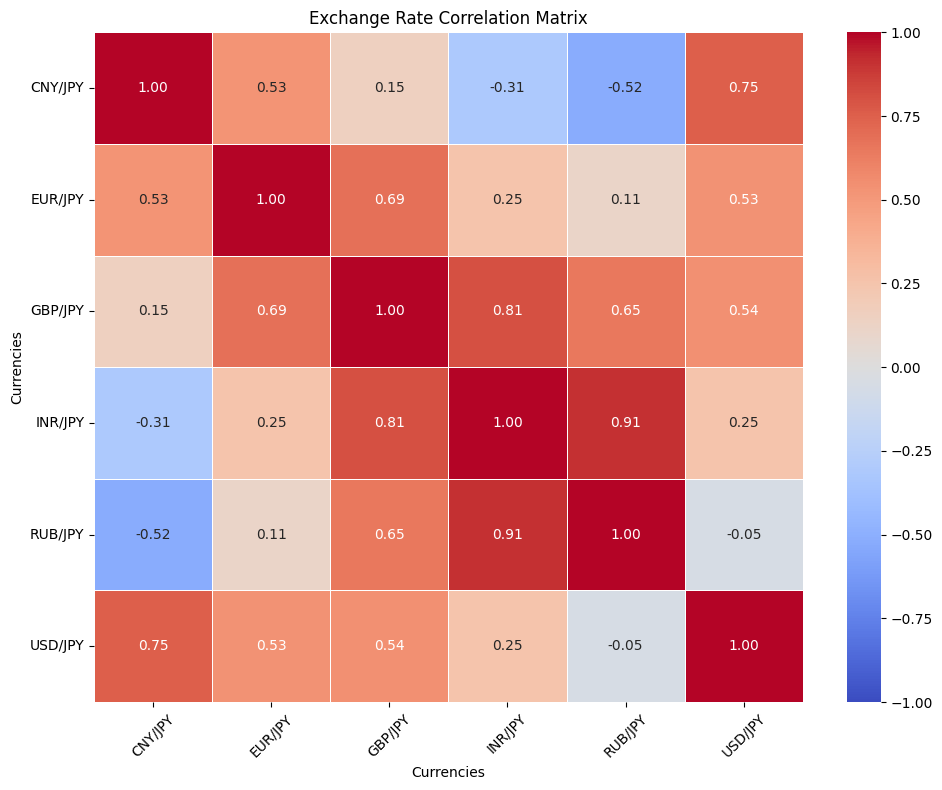

In [166]:
price_data = ex_r_df.pivot(index='Date', columns='Currencies', values='Price')
correlation_matrix = price_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Exchange Rate Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [167]:
# Graph 10 : Exchange Rates thorugh Time 
px.line(ex_r_df, x='Date', y='Price',color='Currencies', color_discrete_map=curreciens_colors, title='Exchange Rates through Time')

<a id="ploi"></a>  
### Places of Interest  
  
  This dataset was meticulously created from scratch by manually gathering detailed information from sources such as [Tripadvisor](https://www.tripadvisor.com), [JNTO](https://www.japan.travel/it/it/), and [Google Earth](https://earth.google.com/web/). The creation process involved extensive research and careful selection of data, focusing on identifying and verifying information related to the top 200 most visited places in Japan. Each attraction was thoughtfully selected and analyzed, including relevant details such as geographic coordinates, category and popularity among visitors. This meticulous effort has resulted in a comprehensive and representative dataset, providing a thorough overview of Japan's major tourist destinations.
  
  [_click here to get back to the top_](#intro)

In [168]:
# Name of the attraction and prefecture
attractions = {"Tokyo Disneyland" : "Chiba",
 "Tokyo DisneySea" : "Chiba",
 "Shinjuku Gyoen National Garden" : "Tokyo",
 "Senso-ji Temple" : "Tokyo",
 "Fushimi Inari Taisha" : "Kyoto",
 "Kinkaku-ji (Golden Pavilion)" : "Kyoto",
 "Mount Fuji" : "Honshu",
 "Arashiyama Bamboo Grove" : "Kyoto",
 "Tokyo Skytree" : "Tokyo",
 "Nara Park" : "Nara",
 "Hiroshima Peace Memorial Park" : "Hiroshima",
 "Osaka Castle" : "Osaka",
 "Ueno Park" : "Tokyo",
 "Himeji Castle" : "Himeji",
 "Meiji Shrine" : "Tokyo",
 "Nikko Toshogu Shrine" : "Tochigi",
 "Dotonbori" : "Osaka",
 "Kenrokuen Garden" : "Kanazawa",
 "Hakone Open-Air Museum" : "Kanagawa",
 "Kyoto Imperial Palace" : "Kyoto",
 "Kiyomizu-dera" : "Kyoto",
 "Nishiki Market" : "Kyoto",
 "Gion District" : "Kyoto",
 "Odaiba" : "Tokyo",
 "Fuji-Q Highland" : "Yamanashi",
 "Nara Dreamland" : "Nara",
 "Huis Ten Bosch" : "Nagasaki",
 "Nagasaki Peace Park" : "Nagasaki",
 "Okinawa Churaumi Aquarium" : "Okinawa",
 "Fukuoka Tower" : "Fukuoka",
 "Osaka Aquarium Kaiyukan" : "Osaka",
 "Ritsurin Garden" : "Takamatsu",
 "Shibuya Crossing" : "Tokyo",
 "Harajuku" : "Tokyo",
 "Ghibli Museum" : "Tokyo",
 "Hakone Ropeway" : "Kanagawa",
 "Lake Kawaguchi" : "Yamanashi",
 "Hasedera Temple" : "Kamakura",
 "Ryoan-ji Temple" : "Kyoto",
 "Todaiji Temple" : "Nara",
 "Shirakawa-go" : "Gifu",
 "Korakuen Garden" : "Okayama",
 "Amanohashidate" : "Kyoto",
 "Ise Grand Shrine" : "Mie",
 "Jigokudani Monkey Park" : "Nagano",
 "Sapporo Snow Festival" : "Hokkaido",
 "Roppongi Hills" : "Tokyo",
 "Yokohama Chinatown" : "Yokohama",
 "Matsumoto Castle" : "Nagano",
 "Nagoya Castle" : "Nagoya",
 "Hakone Shrine" : "Kanagawa",
 "Okinawa World" : "Okinawa",
 "Shibuya Sky" : "Tokyo",
 "Akihabara" : "Tokyo",
 "Nanzen-ji Temple" : "Kyoto",
 "Miyajima Island" : "Hiroshima",
 "Tsukiji Outer Market" : "Tokyo",
 "Okinawa Honto" : "Okinawa",
 "Aso-san" : "Kumamoto",
 "Shiraito Falls" : "Shizuoka",
 "Shinjuku" : "Tokyo",
 "Tsukiji Hongan-ji" : "Tokyo",
 "Kamakura Buddha (Kotoku-in)" : "Kamakura",
 "Ashikaga Flower Park" : "Tochigi",
 "Takeshita Street" : "Tokyo",
 "Kagoshima Aquarium" : "Kagoshima",
 "Beppu Hells" : "Oita",
 "Mount Takao" : "Tokyo",
 "Nabana no Sato" : "Mie",
 "Robot Restaurant" : "Tokyo",
 "Okinawa Peace Memorial Park" : "Okinawa",
 "Yokohama Red Brick Warehouse" : "Yokohama",
 "Rokko Garden Terrace" : "Hyogo",
 "Goryokaku Park" : "Hokkaido",
 "Tokyo National Museum" : "Tokyo",
 "Nijo Castle" : "Kyoto",
 "Shibuya" : "Tokyo",
 "Tenryu-ji Temple" : "Kyoto",
 "TeamLab Borderless" : "Tokyo",
 "Yokohama Landmark Tower" : "Yokohama",
 "Toei Kyoto Studio Park" : "Kyoto",
 "Sakurajima" : "Kagoshima",
 "Nagasaki Atomic Bomb Museum" : "Nagasaki",
 "Iwakuni Kintaikyo Bridge" : "Yamaguchi",
 "Chureito Pagoda" : "Yamanashi",
 "Sumida Aquarium" : "Tokyo",
 "Kobe Harborland" : "Kobe",
 "Matsuyama Castle" : "Ehime",
 "Shosenkyo Gorge" : "Yamanashi",
 "Inuyama Castle" : "Aichi",
 "Umeda Sky Building" : "Osaka",
 "Sapporo TV Tower" : "Hokkaido",
 "Kawagoe" : "Saitama",
 "Nihonbashi" : "Tokyo",
 "Rinku Premium Outlets" : "Osaka",
 "Hakodate Morning Market" : "Hokkaido",
 "Yanaka Ginza" : "Tokyo",
 "Kamakura Hasedera" : "Kamakura",
 "Enoshima" : "Kanagawa",
 "Furano Lavender Fields" : "Hokkaido",
 "Omotesando" : "Tokyo",
 "Abeno Harukas" : "Osaka",
 "Mt Aso" : "Kumamoto",
 "Hamarikyu Gardens" : "Tokyo",
 "Owakudani" : "Kanagawa",
 "Kurashiki Bikan Historical Quarter" : "Okayama",
 "Miyazaki Takachiho Gorge" : "Miyazaki",
 "Hitachi Seaside Park" : "Ibaraki",
 "Tottori Sand Dunes" : "Tottori",
 "Shirakami-Sanchi" : "Aomori",
 "Oboke and Koboke Gorges" : "Tokushima",
 "Noboribetsu Hell Valley" : "Hokkaido",
 "Onuma Quasi-National Park" : "Hokkaido",
 "Jigokudani Monkey Park" : "Nagano",
 "Noto Peninsula" : "Ishikawa",
 "Kurokawa Onsen" : "Kumamoto",
 "Oze National Park" : "Gunma",
 "Chichibu-Tama-Kai National Park" : "Tokyo",
 "Towada-Hachimantai National Park" : "Tohoku",
 "Yakushima" : "Kagoshima",
 "Amami Oshima" : "Kagoshima",
 "Iriomote Island" : "Okinawa",
 "Shiretoko Peninsula" : "Hokkaido",
 "Chubu-Sangaku National Park" : "Honshu",
 "Fuji-Hakone-Izu National Park" : "Honshu",
 "Daisetsuzan National Park" : "Hokkaido",
 "Akan National Park" : "Hokkaido",
 "Setonaikai National Park" : "Seto Inland Sea",
 "Hidaka Mountains" : "Hokkaido",
 "Minami Alps" : "Yamanashi",
 "Ashizuri-Uwakai National Park" : "Kochi",
 "Unzen-Amakusa National Park" : "Kyushu",
 "Yakushima National Park" : "Kagoshima",
 "Chubu-Sangaku National Park" : "Honshu",
 "San'in Kaigan Geopark" : "Tottori",
 "Okinawa Kaigan Quasi-National Park" : "Okinawa",
 "Nagara River" : "Gifu",
 "Lake Toya" : "Hokkaido",
 "Lake Biwa" : "Shiga",
 "Lake Ashi" : "Kanagawa",
 "Lake Tazawa" : "Akita",
 "Otaru Canal" : "Hokkaido",
 "Dotonbori Canal" : "Osaka",
 "Fushimi Sake District" : "Kyoto",
 "Asakusa Culture and Tourist Information Center" : "Tokyo",
 "Yoshino-Kumano National Park" : "Kansai",
 "Azuma Kofuji" : "Fukushima",
 "Minakami" : "Gunma",
 "Kusatsu Onsen" : "Gunma",
 "Beppu Onsen" : "Oita",
 "Noboribetsu Onsen" : "Hokkaido",
 "Atami Onsen" : "Shizuoka",
 "Arima Onsen" : "Hyogo",
 "Yufuin Onsen" : "Oita",
 "Dogo Onsen" : "Ehime",
 "Takaragawa Onsen" : "Gunma",
 "Ginzan Onsen" : "Yamagata",
 "Shimoda" : "Shizuoka",
 "Kinosaki Onsen" : "Hyogo",
 "Hakone Onsen" : "Kanagawa",
 "Gero Onsen" : "Gifu",
 "Yudanaka Onsen" : "Nagano",
 "Hoshinoya Karuizawa" : "Nagano",
 "Nozawa Onsen" : "Nagano",
 "Zao Onsen" : "Yamagata",
 "Manza Onsen" : "Gunma",
 "Shirahama Onsen" : "Wakayama",
 "Ibusuki Onsen" : "Kagoshima",
 "Matsue Vogel Park" : "Shimane",
 "Fuji Five Lakes" : "Yamanashi",
 "Okinawa Churaumi Aquarium" : "Okinawa",
 "Osaka Castle Park" : "Osaka",
 "Roppongi Hills" : "Tokyo",
 "Sapporo TV Tower" : "Hokkaido",
 "Tokyo Tower" : "Tokyo",
 "Sumida Aquarium" : "Tokyo",
 "Kawasaki Daishi" : "Kanagawa",
 "Gotokuji Temple" : "Tokyo",
 "Nezu Shrine" : "Tokyo",
 "Tsurugaoka Hachimangu" : "Kamakura",
 "Amanohashidate" : "Kyoto",
 "Inokashira Park" : "Tokyo",
 "Sankei-en Garden" : "Yokohama",
 "Roppongi Hills Mori Art Museum" : "Tokyo",
 "Hakone Open-Air Museum" : "Kanagawa",
 "Edo-Tokyo Museum" : "Tokyo",
 "National Museum of Nature and Science" : "Tokyo",
 "Ghibli Museum" : "Tokyo",
 "National Museum of Western Art" : "Tokyo",
 "Kyoto National Museum" : "Kyoto",
 "Osaka Museum of History" : "Osaka",
 "Churaumi Aquarium" : "Okinawa",
 "Nara National Museum" : "Nara",
 "Hokkaido Museum" : "Hokkaido",
 "Peace Memorial Museum" : "Hiroshima",
 "Toyota Commemorative Museum of Industry and Technology" : "Nagoya",
 "Cup Noodles Museum" : "Yokohama",
 "Ninja Museum of Igaryu" : "Mie",
 "Shitamachi Tanabata Matsuri" : "Tokyo",
 "Sanno Matsuri" : "Tokyo"}

# Kind of attraction. Categories: Natural Parks and Gardens, Theme Parks, Museums and Zoos, Temples and Shrines, Monuments, Sculptures and Constructions
category={
    'Tokyo Disneyland': 'Theme Parks',
    'Tokyo DisneySea': 'Theme Parks',
    'Shinjuku Gyoen National Garden': 'Natural Parks and Gardens',
    'Senso-ji Temple': 'Temples and Shrines',
    'Fushimi Inari Taisha': 'Temples and Shrines',
    'Kinkaku-ji (Golden Pavilion)': 'Temples and Shrines',
    'Mount Fuji': 'Natural Parks and Gardens',
    'Arashiyama Bamboo Grove': 'Natural Parks and Gardens',
    'Tokyo Skytree': 'Monuments, Sculptures and Constructions',
    'Nara Park': 'Natural Parks and Gardens',
    'Hiroshima Peace Memorial Park': 'Monuments, Sculptures and Constructions',
    'Osaka Castle': 'Monuments, Sculptures and Constructions',
    'Ueno Park': 'Natural Parks and Gardens',
    'Himeji Castle': 'Monuments, Sculptures and Constructions',
    'Meiji Shrine': 'Temples and Shrines',
    'Nikko Toshogu Shrine': 'Temples and Shrines',
    'Dotonbori': 'Monuments, Sculptures and Constructions',
    'Kenrokuen Garden': 'Natural Parks and Gardens',
    'Hakone Open-Air Museum': 'Museums and Zoos',
    'Kyoto Imperial Palace': 'Monuments, Sculptures and Constructions',
    'Kiyomizu-dera': 'Temples and Shrines',
    'Nishiki Market': 'Monuments, Sculptures and Constructions',
    'Gion District': 'Monuments, Sculptures and Constructions',
    'Odaiba': 'Monuments, Sculptures and Constructions',
    'Fuji-Q Highland': 'Theme Parks',
    'Nara Dreamland': 'Theme Parks',
    'Huis Ten Bosch': 'Theme Parks',
    'Nagasaki Peace Park': 'Monuments, Sculptures and Constructions',
    'Okinawa Churaumi Aquarium': 'Museums and Zoos',
    'Fukuoka Tower': 'Monuments, Sculptures and Constructions',
    'Osaka Aquarium Kaiyukan': 'Museums and Zoos',
    'Ritsurin Garden': 'Natural Parks and Gardens',
    'Shibuya Crossing': 'Monuments, Sculptures and Constructions',
    'Harajuku': 'Monuments, Sculptures and Constructions',
    'Ghibli Museum': 'Museums and Zoos',
    'Hakone Ropeway': 'Monuments, Sculptures and Constructions',
    'Lake Kawaguchi': 'Natural Parks and Gardens',
    'Hasedera Temple': 'Temples and Shrines',
    'Ryoan-ji Temple': 'Temples and Shrines',
    'Todaiji Temple': 'Temples and Shrines',
    'Shirakawa-go': 'Monuments, Sculptures and Constructions',
    'Korakuen Garden': 'Natural Parks and Gardens',
    'Amanohashidate': 'Natural Parks and Gardens',
    'Ise Grand Shrine': 'Temples and Shrines',
    'Jigokudani Monkey Park': 'Natural Parks and Gardens',
    'Sapporo Snow Festival': 'Monuments, Sculptures and Constructions',
    'Roppongi Hills': 'Monuments, Sculptures and Constructions',
    'Yokohama Chinatown': 'Monuments, Sculptures and Constructions',
    'Matsumoto Castle': 'Monuments, Sculptures and Constructions',
    'Nagoya Castle': 'Monuments, Sculptures and Constructions',
    'Hakone Shrine': 'Temples and Shrines',
    'Okinawa World': 'Monuments, Sculptures and Constructions',
    'Shibuya Sky': 'Monuments, Sculptures and Constructions',
    'Akihabara': 'Monuments, Sculptures and Constructions',
    'Nanzen-ji Temple': 'Temples and Shrines',
    'Miyajima Island': 'Natural Parks and Gardens',
    'Tsukiji Outer Market': 'Monuments, Sculptures and Constructions',
    'Okinawa Honto': 'Natural Parks and Gardens',
    'Aso-san': 'Natural Parks and Gardens',
    'Shiraito Falls': 'Natural Parks and Gardens',
    'Shinjuku': 'Monuments, Sculptures and Constructions',
    'Tsukiji Hongan-ji': 'Temples and Shrines',
    'Kamakura Buddha (Kotoku-in)': 'Temples and Shrines',
    'Ashikaga Flower Park': 'Natural Parks and Gardens',
    'Takeshita Street': 'Monuments, Sculptures and Constructions',
    'Kagoshima Aquarium': 'Museums and Zoos',
    'Beppu Hells': 'Natural Parks and Gardens',
    'Mount Takao': 'Natural Parks and Gardens',
    'Nabana no Sato': 'Natural Parks and Gardens',
    'Robot Restaurant': 'Monuments, Sculptures and Constructions',
    'Okinawa Peace Memorial Park': 'Monuments, Sculptures and Constructions',
    'Yokohama Red Brick Warehouse': 'Monuments, Sculptures and Constructions',
    'Rokko Garden Terrace': 'Natural Parks and Gardens',
    'Goryokaku Park': 'Natural Parks and Gardens',
    'Tokyo National Museum': 'Museums and Zoos',
    'Nijo Castle': 'Monuments, Sculptures and Constructions',
    'Shibuya': 'Monuments, Sculptures and Constructions',
    'Tenryu-ji Temple': 'Temples and Shrines',
    'TeamLab Borderless': 'Museums and Zoos',
    'Yokohama Landmark Tower': 'Monuments, Sculptures and Constructions',
    'Toei Kyoto Studio Park': 'Theme Parks',
    'Sakurajima': 'Natural Parks and Gardens',
    'Nagasaki Atomic Bomb Museum': 'Museums and Zoos',
    'Iwakuni Kintaikyo Bridge': 'Monuments, Sculptures and Constructions',
    'Chureito Pagoda': 'Temples and Shrines',
    'Sumida Aquarium': 'Museums and Zoos',
    'Kobe Harborland': 'Monuments, Sculptures and Constructions',
    'Matsuyama Castle': 'Monuments, Sculptures and Constructions',
    'Shosenkyo Gorge': 'Natural Parks and Gardens',
    'Inuyama Castle': 'Monuments, Sculptures and Constructions',
    'Umeda Sky Building': 'Monuments, Sculptures and Constructions',
    'Sapporo TV Tower': 'Monuments, Sculptures and Constructions',
    'Kawagoe': 'Monuments, Sculptures and Constructions',
    'Nihonbashi': 'Monuments, Sculptures and Constructions',
    'Rinku Premium Outlets': 'Monuments, Sculptures and Constructions',
    'Hakodate Morning Market': 'Monuments, Sculptures and Constructions',
    'Yanaka Ginza': 'Monuments, Sculptures and Constructions',
    'Kamakura Hasedera': 'Temples and Shrines',
    'Enoshima': 'Natural Parks and Gardens',
    'Furano Lavender Fields': 'Natural Parks and Gardens',
    'Omotesando': 'Monuments, Sculptures and Constructions',
    'Abeno Harukas': 'Monuments, Sculptures and Constructions',
    'Mt Aso': 'Natural Parks and Gardens',
    'Hamarikyu Gardens': 'Natural Parks and Gardens',
    'Owakudani': 'Natural Parks and Gardens',
    'Kurashiki Bikan Historical Quarter': 'Monuments, Sculptures and Constructions',
    'Miyazaki Takachiho Gorge': 'Natural Parks and Gardens',
    'Hitachi Seaside Park': 'Natural Parks and Gardens',
    'Tottori Sand Dunes': 'Natural Parks and Gardens',
    'Shirakami-Sanchi': 'Natural Parks and Gardens',
    'Oboke and Koboke Gorges': 'Natural Parks and Gardens',
    'Noboribetsu Hell Valley': 'Natural Parks and Gardens',
    'Onuma Quasi-National Park': 'Natural Parks and Gardens',
    'Noto Peninsula': 'Natural Parks and Gardens',
    'Kurokawa Onsen': 'Natural Parks and Gardens',
    'Oze National Park': 'Natural Parks and Gardens',
    'Chichibu-Tama-Kai National Park': 'Natural Parks and Gardens',
    'Towada-Hachimantai National Park': 'Natural Parks and Gardens',
    'Yakushima': 'Natural Parks and Gardens',
    'Amami Oshima': 'Natural Parks and Gardens',
    'Iriomote Island': 'Natural Parks and Gardens',
    'Shiretoko Peninsula': 'Natural Parks and Gardens',
    'Chubu-Sangaku National Park': 'Natural Parks and Gardens',
    'Fuji-Hakone-Izu National Park': 'Natural Parks and Gardens',
    'Daisetsuzan National Park': 'Natural Parks and Gardens',
    'Akan National Park': 'Natural Parks and Gardens',
    'Setonaikai National Park': 'Natural Parks and Gardens',
    'Hidaka Mountains': 'Natural Parks and Gardens',
    'Minami Alps': 'Natural Parks and Gardens',
    'Ashizuri-Uwakai National Park': 'Natural Parks and Gardens',
    'Unzen-Amakusa National Park': 'Natural Parks and Gardens',
    'Yakushima National Park': 'Natural Parks and Gardens',
    "San'in Kaigan Geopark": 'Natural Parks and Gardens',
    'Okinawa Kaigan Quasi-National Park': 'Natural Parks and Gardens',
    'Nagara River': 'Natural Parks and Gardens',
    'Lake Toya': 'Natural Parks and Gardens',
    'Lake Biwa': 'Natural Parks and Gardens',
    'Lake Ashi': 'Natural Parks and Gardens',
    'Lake Tazawa': 'Natural Parks and Gardens',
    'Otaru Canal': 'Monuments, Sculptures and Constructions',
    'Dotonbori Canal': 'Monuments, Sculptures and Constructions',
    'Fushimi Sake District': 'Monuments, Sculptures and Constructions',
    'Asakusa Culture and Tourist Information Center': 'Monuments, Sculptures and Constructions',
    'Yoshino-Kumano National Park': 'Natural Parks and Gardens',
    'Azuma Kofuji': 'Natural Parks and Gardens',
    'Minakami': 'Natural Parks and Gardens',
    'Kusatsu Onsen': 'Natural Parks and Gardens',
    'Beppu Onsen': 'Natural Parks and Gardens',
    'Noboribetsu Onsen': 'Natural Parks and Gardens',
    'Atami Onsen': 'Natural Parks and Gardens',
    'Arima Onsen': 'Natural Parks and Gardens',
    'Yufuin Onsen': 'Natural Parks and Gardens',
    'Dogo Onsen': 'Natural Parks and Gardens',
    'Takaragawa Onsen': 'Natural Parks and Gardens',
    'Ginzan Onsen': 'Natural Parks and Gardens',
    'Shimoda': 'Natural Parks and Gardens',
    'Kinosaki Onsen': 'Natural Parks and Gardens',
    'Hakone Onsen': 'Natural Parks and Gardens',
    'Gero Onsen': 'Natural Parks and Gardens',
    'Yudanaka Onsen': 'Natural Parks and Gardens',
    'Hoshinoya Karuizawa': 'Natural Parks and Gardens',
    'Nozawa Onsen': 'Natural Parks and Gardens',
    'Zao Onsen': 'Natural Parks and Gardens',
    'Manza Onsen': 'Natural Parks and Gardens',
    'Shirahama Onsen': 'Natural Parks and Gardens',
    'Ibusuki Onsen': 'Natural Parks and Gardens',
    'Matsue Vogel Park': 'Museums and Zoos',
    'Fuji Five Lakes': 'Natural Parks and Gardens',
    'Osaka Castle Park': 'Natural Parks and Gardens',
    'Tokyo Tower': 'Monuments, Sculptures and Constructions',
    'Kawasaki Daishi': 'Temples and Shrines',
    'Gotokuji Temple': 'Temples and Shrines',
    'Nezu Shrine': 'Temples and Shrines',
    'Tsurugaoka Hachimangu': 'Temples and Shrines',
    'Inokashira Park': 'Natural Parks and Gardens',
    'Sankei-en Garden': 'Natural Parks and Gardens',
    'Roppongi Hills Mori Art Museum': 'Museums and Zoos',
    'Edo-Tokyo Museum': 'Museums and Zoos',
    'National Museum of Nature and Science': 'Museums and Zoos',
    'National Museum of Western Art': 'Museums and Zoos',
    'Kyoto National Museum': 'Museums and Zoos',
    'Osaka Museum of History': 'Museums and Zoos',
    'Churaumi Aquarium': 'Museums and Zoos',
    'Nara National Museum': 'Museums and Zoos',
    'Hokkaido Museum': 'Museums and Zoos',
    'Peace Memorial Museum': 'Museums and Zoos',
    'Toyota Commemorative Museum of Industry and Technology': 'Museums and Zoos',
    'Cup Noodles Museum': 'Museums and Zoos',
    'Ninja Museum of Igaryu': 'Museums and Zoos',
    'Shitamachi Tanabata Matsuri': 'Monuments, Sculptures and Constructions',
    'Sanno Matsuri': 'Monuments, Sculptures and Constructions'
}

# Number of visitors per year. Categories: Between 1 and 5 Millions, Between 5 and 10 Millions, Less than 1 Million, More than 10 Millions
visitors={
    'Tokyo Disneyland': 'Less than 1 Million',
    'Tokyo DisneySea': 'Less than 1 Million',
    'Shinjuku Gyoen National Garden': 'Between 5 and 10 Millions',
    'Senso-ji Temple': 'Less than 1 Million',
    'Fushimi Inari Taisha': 'Between 1 and 5 Millions',
    'Kinkaku-ji (Golden Pavilion)': 'Between 1 and 5 Millions',
    'Mount Fuji': 'Between 5 and 10 Millions',
    'Arashiyama Bamboo Grove': 'Between 5 and 10 Millions',
    'Tokyo Skytree': 'Less than 1 Million',
    'Nara Park': 'Between 5 and 10 Millions',
    'Hiroshima Peace Memorial Park': 'Between 1 and 5 Millions',
    'Osaka Castle': 'Between 1 and 5 Millions',
    'Ueno Park': 'Between 5 and 10 Millions',
    'Himeji Castle': 'Between 5 and 10 Millions',
    'Meiji Shrine': 'Between 1 and 5 Millions',
    'Nikko Toshogu Shrine': 'Between 5 and 10 Millions',
    'Dotonbori': 'Less than 1 Million',
    'Kenrokuen Garden': 'More than 10 Millions',
    'Hakone Open-Air Museum': 'Between 5 and 10 Millions',
    'Kyoto Imperial Palace': 'Between 5 and 10 Millions',
    'Kiyomizu-dera': 'Between 1 and 5 Millions',
    'Nishiki Market': 'Between 5 and 10 Millions',
    'Gion District': 'Between 5 and 10 Millions',
    'Odaiba': 'Between 5 and 10 Millions',
    'Fuji-Q Highland': 'Between 5 and 10 Millions',
    'Nara Dreamland': 'More than 10 Millions',
    'Huis Ten Bosch': 'Between 5 and 10 Millions',
    'Nagasaki Peace Park': 'Between 5 and 10 Millions',
    'Okinawa Churaumi Aquarium': 'Between 5 and 10 Millions',
    'Fukuoka Tower': 'More than 10 Millions',
    'Osaka Aquarium Kaiyukan': 'Between 5 and 10 Millions',
    'Ritsurin Garden': 'More than 10 Millions',
    'Shibuya Crossing': 'Less than 1 Million',
    'Harajuku': 'Between 5 and 10 Millions',
    'Ghibli Museum': 'Between 5 and 10 Millions',
    'Hakone Ropeway': 'More than 10 Millions',
    'Lake Kawaguchi': 'Between 5 and 10 Millions',
    'Hasedera Temple': 'More than 10 Millions',
    'Ryoan-ji Temple': 'More than 10 Millions',
    'Todaiji Temple': 'Between 5 and 10 Millions',
    'Shirakawa-go': 'Between 5 and 10 Millions',
    'Korakuen Garden': 'More than 10 Millions',
    'Amanohashidate': 'More than 10 Millions',
    'Ise Grand Shrine': 'Between 5 and 10 Millions',
    'Jigokudani Monkey Park': 'More than 10 Millions',
    'Sapporo Snow Festival': 'Between 5 and 10 Millions',
    'Roppongi Hills': 'Between 5 and 10 Millions',
    'Yokohama Chinatown': 'Between 5 and 10 Millions',
    'Matsumoto Castle': 'Between 5 and 10 Millions',
    'Nagoya Castle': 'Between 5 and 10 Millions',
    'Hakone Shrine': 'More than 10 Millions',
    'Okinawa World': 'More than 10 Millions',
    'Shibuya Sky': 'More than 10 Millions',
    'Akihabara': 'Between 5 and 10 Millions',
    'Nanzen-ji Temple': 'More than 10 Millions',
    'Miyajima Island': 'Between 5 and 10 Millions',
    'Tsukiji Outer Market': 'Between 5 and 10 Millions',
    'Okinawa Honto': 'More than 10 Millions',
    'Aso-san': 'More than 10 Millions',
    'Shiraito Falls': 'More than 10 Millions',
    'Shinjuku': 'Between 5 and 10 Millions',
    'Tsukiji Hongan-ji': 'More than 10 Millions',
    'Kamakura Buddha (Kotoku-in)': 'Between 5 and 10 Millions',
    'Ashikaga Flower Park': 'More than 10 Millions',
    'Takeshita Street': 'Between 5 and 10 Millions',
    'Kagoshima Aquarium': 'More than 10 Millions',
    'Beppu Hells': 'More than 10 Millions',
    'Mount Takao': 'Between 5 and 10 Millions',
    'Nabana no Sato': 'More than 10 Millions',
    'Robot Restaurant': 'More than 10 Millions',
    'Okinawa Peace Memorial Park': 'More than 10 Millions',
    'Yokohama Red Brick Warehouse': 'Between 5 and 10 Millions',
    'Rokko Garden Terrace': 'More than 10 Millions',
    'Goryokaku Park': 'More than 10 Millions',
    'Tokyo National Museum': 'Between 5 and 10 Millions',
    'Nijo Castle': 'Between 5 and 10 Millions',
    'Shibuya': 'Between 5 and 10 Millions',
    'Tenryu-ji Temple': 'More than 10 Millions',
    'TeamLab Borderless': 'Between 5 and 10 Millions',
    'Yokohama Landmark Tower': 'More than 10 Millions',
    'Toei Kyoto Studio Park': 'More than 10 Millions',
    'Sakurajima': 'More than 10 Millions',
    'Nagasaki Atomic Bomb Museum': 'More than 10 Millions',
    'Iwakuni Kintaikyo Bridge': 'More than 10 Millions',
    'Chureito Pagoda': 'More than 10 Millions',
    'Sumida Aquarium': 'More than 10 Millions',
    'Kobe Harborland': 'More than 10 Millions',
    'Matsuyama Castle': 'More than 10 Millions',
    'Shosenkyo Gorge': 'More than 10 Millions',
    'Inuyama Castle': 'More than 10 Millions',
    'Umeda Sky Building': 'Between 5 and 10 Millions',
    'Sapporo TV Tower': 'More than 10 Millions',
    'Kawagoe': 'More than 10 Millions',
    'Nihonbashi': 'More than 10 Millions',
    'Rinku Premium Outlets': 'More than 10 Millions',
    'Hakodate Morning Market': 'More than 10 Millions',
    'Yanaka Ginza': 'More than 10 Millions',
    'Kamakura Hasedera': 'More than 10 Millions',
    'Enoshima': 'More than 10 Millions',
    'Furano Lavender Fields': 'More than 10 Millions',
    'Omotesando': 'Between 5 and 10 Millions',
    'Abeno Harukas': 'More than 10 Millions',
    'Mt Aso': 'More than 10 Millions',
    'Hamarikyu Gardens': 'More than 10 Millions',
    'Owakudani': 'More than 10 Millions',
    'Kurashiki Bikan Historical Quarter': 'More than 10 Millions',
    'Miyazaki Takachiho Gorge': 'More than 10 Millions',
    'Hitachi Seaside Park': 'Between 5 and 10 Millions',
    'Tottori Sand Dunes': 'More than 10 Millions',
    'Shirakami-Sanchi': 'More than 10 Millions',
    'Oboke and Koboke Gorges': 'More than 10 Millions',
    'Noboribetsu Hell Valley': 'More than 10 Millions',
    'Onuma Quasi-National Park': 'More than 10 Millions',
    'Noto Peninsula': 'More than 10 Millions',
    'Kurokawa Onsen': 'More than 10 Millions',
    'Oze National Park': 'More than 10 Millions',
    'Chichibu-Tama-Kai National Park': 'More than 10 Millions',
    'Towada-Hachimantai National Park': 'More than 10 Millions',
    'Yakushima': 'More than 10 Millions',
    'Amami Oshima': 'More than 10 Millions',
    'Iriomote Island': 'More than 10 Millions',
    'Shiretoko Peninsula': 'More than 10 Millions',
    'Chubu-Sangaku National Park': 'More than 10 Millions',
    'Fuji-Hakone-Izu National Park': 'Between 5 and 10 Millions',
    'Daisetsuzan National Park': 'More than 10 Millions',
    'Akan National Park': 'More than 10 Millions',
    'Setonaikai National Park': 'More than 10 Millions',
    'Hidaka Mountains': 'More than 10 Millions',
    'Minami Alps': 'More than 10 Millions',
    'Ashizuri-Uwakai National Park': 'More than 10 Millions',
    'Unzen-Amakusa National Park': 'More than 10 Millions',
    'Yakushima National Park': 'More than 10 Millions',
    "San'in Kaigan Geopark": 'More than 10 Millions',
    'Okinawa Kaigan Quasi-National Park': 'More than 10 Millions',
    'Nagara River': 'More than 10 Millions',
    'Lake Toya': 'More than 10 Millions',
    'Lake Biwa': 'More than 10 Millions',
    'Lake Ashi': 'More than 10 Millions',
    'Lake Tazawa': 'More than 10 Millions',
    'Otaru Canal': 'More than 10 Millions',
    'Dotonbori Canal': 'Between 5 and 10 Millions',
    'Fushimi Sake District': 'More than 10 Millions',
    'Asakusa Culture and Tourist Information Center': 'More than 10 Millions',
    'Yoshino-Kumano National Park': 'More than 10 Millions',
    'Azuma Kofuji': 'More than 10 Millions',
    'Minakami': 'More than 10 Millions',
    'Kusatsu Onsen': 'More than 10 Millions',
    'Beppu Onsen': 'More than 10 Millions',
    'Noboribetsu Onsen': 'More than 10 Millions',
    'Atami Onsen': 'More than 10 Millions',
    'Arima Onsen': 'More than 10 Millions',
    'Yufuin Onsen': 'More than 10 Millions',
    'Dogo Onsen': 'More than 10 Millions',
    'Takaragawa Onsen': 'More than 10 Millions',
    'Ginzan Onsen': 'More than 10 Millions',
    'Shimoda': 'More than 10 Millions',
    'Kinosaki Onsen': 'More than 10 Millions',
    'Hakone Onsen': 'More than 10 Millions',
    'Gero Onsen': 'More than 10 Millions',
    'Yudanaka Onsen': 'More than 10 Millions',
    'Hoshinoya Karuizawa': 'More than 10 Millions',
    'Nozawa Onsen': 'More than 10 Millions',
    'Zao Onsen': 'More than 10 Millions',
    'Manza Onsen': 'More than 10 Millions',
    'Shirahama Onsen': 'More than 10 Millions',
    'Ibusuki Onsen': 'More than 10 Millions',
    'Matsue Vogel Park': 'More than 10 Millions',
    'Fuji Five Lakes': 'More than 10 Millions',
    'Osaka Castle Park': 'Between 5 and 10 Millions',
    'Tokyo Tower': 'Between 1 and 5 Millions',
    'Kawasaki Daishi': 'More than 10 Millions',
    'Gotokuji Temple': 'More than 10 Millions',
    'Nezu Shrine': 'More than 10 Millions',
    'Tsurugaoka Hachimangu': 'More than 10 Millions',
    'Inokashira Park': 'More than 10 Millions',
    'Sankei-en Garden': 'More than 10 Millions',
    'Roppongi Hills Mori Art Museum': 'More than 10 Millions',
    'Edo-Tokyo Museum': 'More than 10 Millions',
    'National Museum of Nature and Science': 'More than 10 Millions',
    'National Museum of Western Art': 'More than 10 Millions',
    'Kyoto National Museum': 'More than 10 Millions',
    'Osaka Museum of History': 'More than 10 Millions',
    'Churaumi Aquarium': 'Between 5 and 10 Millions',
    'Nara National Museum': 'More than 10 Millions',
    'Hokkaido Museum': 'More than 10 Millions',
    'Peace Memorial Museum': 'Between 5 and 10 Millions',
    'Toyota Commemorative Museum of Industry and Technology': 'More than 10 Millions',
    'Cup Noodles Museum': 'More than 10 Millions',
    'Ninja Museum of Igaryu': 'More than 10 Millions',
    'Shitamachi Tanabata Matsuri': 'More than 10 Millions',
    'Sanno Matsuri': 'More than 10 Millions'}

# Attraction latitudes
latitude = {"Tokyo Disneyland" : "35°37'34.79\"N",
    "Tokyo DisneySea" : "35°37'36\"N",
    "Shinjuku Gyoen National Garden" : "35°41'06\"N",
    "Senso-ji Temple" : "35°42'53\"N",
    "Fushimi Inari Taisha" : "34°58'03\"N",
    "Kinkaku-ji (Golden Pavilion)" : "35°02'21\"N",
    "Mount Fuji" : "35°21'38\"N",
    "Arashiyama Bamboo Grove" : "35°01'00\"N",
    "Tokyo Skytree" : "35°42'36\"N",
    "Nara Park" : "34°41'06\"N ",
    "Hiroshima Peace Memorial Park" : "34°23'33\"N",
    "Osaka Castle" : "34°41'14\"N",
    "Ueno Park" : "35°42'53\"N",
    "Himeji Castle" : "34°50'22\"N",
    "Meiji Shrine" : "35°40'35\"N",
    "Nikko Toshogu Shrine" : "36°45'29\"N",
    "Dotonbori" : "34°40'06\"N",
    "Kenrokuen Garden" : "36°33'47\"N",
    "Hakone Open-Air Museum" : "35°14'41\"N",
    "Kyoto Imperial Palace" : "35°01'20\"N",
    "Kiyomizu-dera" : "34°59'40\"N",
    "Nishiki Market" : "35°00'18\"N",
    "Gion District" : "35°00'16\"N",
    "Odaiba" : "35°37'07\"N",
    "Fuji-Q Highland" : "35°29'13\"N",
    "Nara Dreamland" : "34°42'04\"N",
    "Huis Ten Bosch" : "33°05'22\"N",
    "Nagasaki Peace Park" : "32°46'35\"N",
    "Okinawa Churaumi Aquarium" : "26°41'30\"N",
    "Fukuoka Tower" : "33°35'18\"N",
    "Osaka Aquarium Kaiyukan" : "34°39'18\"N",
    "Ritsurin Garden" : "34°19'22\"N",
    "Shibuya Crossing" : "35°39'35\"N",
    "Harajuku" : "35°40'00\"N",
    "Ghibli Museum" : "35°41'32\"N",
    "Hakone Ropeway" : "35°14'34\"N",
    "Lake Kawaguchi" : "35°31'36\"N",
    "Hasedera Temple" : "35°19'13\"N",
    "Ryoan-ji Temple" : "35°02'23\"N",
    "Todaiji Temple" : "34°41'31\"N",
    "Shirakawa-go" : "36°15'32\"N",
    "Korakuen Garden" : "34°39'36\"N",
    "Amanohashidate" : "35°34'14\"N",
    "Ise Grand Shrine" : "34°27'05\"N",
    "Jigokudani Monkey Park" : "36°44'29\"N",
    "Sapporo Snow Festival" : "43°03'27\"N",
    "Roppongi Hills" : "35°39'47\"N",
    "Yokohama Chinatown" : "35°26'33\"N",
    "Matsumoto Castle" : "36°14'05\"N",
    "Nagoya Castle" : "35°11'58\"N",
    "Hakone Shrine" : "35°12'16\"N",
    "Okinawa World" : "26°08'17\"N",
    "Shibuya Sky" : "35°39'32\"N",
    "Akihabara" : "35°41'59\"N",
    "Nanzen-ji Temple" : "35°00'34\"N",
    "Miyajima Island" : "34°17'37\"N",
    "Tsukiji Outer Market" : "35°39'43\"N",
    "Okinawa Honto" : "26°30'00\"N",
    "Aso-san" : "32°53'00\"N",
    "Shiraito Falls" : "35°18'35\"N",
    "Shinjuku" : "35°41'22\"N",
    "Tsukiji Hongan-ji" : "35°40'22\"N",
    "Kamakura Buddha (Kotoku-in)" : "35°18'06\"N",
    "Ashikaga Flower Park" : "36°19'47\"N",
    "Takeshita Street" : "35°40'17\"N",
    "Kagoshima Aquarium" : "31°35'25\"N",
    "Beppu Hells" : "33°17'28\"N",
    "Mount Takao" : "35°37'30\"N",
    "Nabana no Sato" : "35°03'06\"N",
    "Robot Restaurant" : "35°41'26\"N",
    "Okinawa Peace Memorial Park" : "26°05'00\"N",
    "Yokohama Red Brick Warehouse" : "35°27'03\"N",
    "Rokko Garden Terrace" : "34°45'54\"N",
    "Goryokaku Park" : "41°47'48\"N",
    "Tokyo National Museum" : "35°42'53\"N",
    "Nijo Castle" : "35°00'37\"N",
    "Shibuya" : "35°39'33\"N",
    "Tenryu-ji Temple" : "35°00'13\"N",
    "TeamLab Borderless" : "35°37'17\"N",
    "Yokohama Landmark Tower" : "35°27'09\"N",
    "Toei Kyoto Studio Park" : "35°02'21\"N",
    "Sakurajima" : "31°35'58\"N",
    "Nagasaki Atomic Bomb Museum" : "32°45'33\"N",
    "Iwakuni Kintaikyo Bridge" : "34°10'30\"N",
    "Chureito Pagoda" : "35°29'20\"N",
    "Sumida Aquarium" : "35°42'41\"N",
    "Kobe Harborland" : "34°40'45\"N",
    "Matsuyama Castle" : "33°50'51\"N",
    "Shosenkyo Gorge" : "35°42'53\"N",
    "Inuyama Castle" : "35°23'22\"N",
    "Umeda Sky Building" : "34°42'15\"N",
    "Sapporo TV Tower" : "43°03'29\"N",
    "Kawagoe" : "35°55'45\"N",
    "Nihonbashi" : "35°41'09\"N",
    "Rinku Premium Outlets" : "34°24'55\"N",
    "Hakodate Morning Market" : "41°46'52\"N",
    "Yanaka Ginza" : "35°43'50\"N",
    "Kamakura Hasedera" : "35°18'19\"N",
    "Enoshima" : "35°18'05\"N",
    "Furano Lavender Fields" : "43°20'26\"N",
    "Omotesando" : "35°40'08\"N",
    "Abeno Harukas" : "34°38'30\"N",
    "Mt Aso" : "32°53'00\"N",
    "Hamarikyu Gardens" : "35°39'22\"N",
    "Owakudani" : "35°14'24\"N",
    "Kurashiki Bikan Historical Quarter" : "34°35'14\"N",
    "Miyazaki Takachiho Gorge" : "32°41'36\"N",
    "Hitachi Seaside Park" : "36°24'09\"N",
    "Tottori Sand Dunes" : "35°32'04\"N",
    "Shirakami-Sanchi" : "40°32'00\"N",
    "Oboke and Koboke Gorges" : "33°55'03\"N",
    "Noboribetsu Hell Valley" : "42°30'40\"N",
    "Onuma Quasi-National Park" : "41°58'00\"N",
    "Jigokudani Monkey Park" : "36°43'35\"N",
    "Noto Peninsula" : "37°18'00\"N",
    "Kurokawa Onsen" : "33°04'44\"N",
    "Oze National Park" : "36°54'10\"N",
    "Chichibu-Tama-Kai National Park" : "35°57'00\"N",
    "Towada-Hachimantai National Park" : "40°27'00\"N",
    "Yakushima" : "30°22'35\"N",
    "Amami Oshima" : "28°21'24\"N",
    "Iriomote Island" : "24°20'45\"N",
    "Shiretoko Peninsula" : "44°05'00\"N",
    "Chubu-Sangaku National Park" : "36°16'00\"N",
    "Fuji-Hakone-Izu National Park" : "35°21'38\"N",
    "Daisetsuzan National Park" : "43°39'27\"N",
    "Akan National Park" : "43°27'29\"N",
    "Setonaikai National Park" : "34°19'35\"N",
    "Hidaka Mountains" : "42°42'00\"N",
    "Minami Alps" : "35°34'00\"N",
    "Ashizuri-Uwakai National Park" : "32°45'00\"N",
    "Unzen-Amakusa National Park" : "32°44'00\"N",
    "Yakushima National Park" : "30°22'35\"N",
    "San'in Kaigan Geopark" : "35°38'00\"N",
    "Okinawa Kaigan Quasi-National Park" : "26°12'00\"N",
    "Nagara River" : "35°25'10\"N",
    "Lake Toya" : "42°36'00\"N",
    "Lake Biwa" : "35°15'00\"N",
    "Lake Ashi" : "35°12'36\"N",
    "Lake Tazawa" : "39°42'30\"N",
    "Otaru Canal" : "43°11'25\"N",
    "Dotonbori Canal" : "34°40'06\"N",
    "Fushimi Sake District" : "34°55'00\"N",
    "Asakusa Culture and Tourist Information Center" : "35°42'43\"N",
    "Yoshino-Kumano National Park" : "34°14'00\"N",
    "Azuma Kofuji" : "37°42'27\"N",
    "Minakami" : "36°39'00\"N",
    "Kusatsu Onsen" : "36°37'29\"N",
    "Beppu Onsen" : "33°18'00\"N",
    "Noboribetsu Onsen" : "42°30'26\"N",
    "Atami Onsen" : "35°06'40\"N",
    "Arima Onsen" : "34°47'54\"N",
    "Yufuin Onsen" : "33°15'29\"N",
    "Dogo Onsen" : "33°50'47\"N",
    "Takaragawa Onsen" : "36°48'38\"N",
    "Ginzan Onsen" : "38°32'43\"N",
    "Shimoda" : "34°39'00\"N",
    "Kinosaki Onsen" : "35°37'00\"N",
    "Hakone Onsen" : "35°11'30\"N",
    "Gero Onsen" : "35°48'36\"N",
    "Yudanaka Onsen" : "36°43'59\"N",
    "Hoshinoya Karuizawa" : "36°21'14\"N",
    "Nozawa Onsen" : "36°55'20\"N",
    "Zao Onsen" : "38°09'00\"N",
    "Manza Onsen" : "36°38'36\"N",
    "Shirahama Onsen" : "33°40'00\"N",
    "Ibusuki Onsen" : "31°14'00\"N",
    "Matsue Vogel Park" : "35°27'29\"N",
    "Fuji Five Lakes" : "35°28'00\"N",
    "Okinawa Churaumi Aquarium" : "26°41'30\"N",
    "Osaka Castle Park" : "34°41'21\"N",
    "Roppongi Hills" : "35°39'47\"N",
    "Sapporo TV Tower" : "43°03'29\"N",
    "Tokyo Tower" : "35°39'30\"N",
    "Sumida Aquarium" : "35°42'41\"N",
    "Kawasaki Daishi" : "35°31'09\"N",
    "Gotokuji Temple" : "35°39'28\"N",
    "Nezu Shrine" : "35°43'51\"N",
    "Tsurugaoka Hachimangu" : "35°19'38\"N",
    "Amanohashidate" : "35°34'14\"N",
    "Inokashira Park" : "35°41'16\"N",
    "Sankei-en Garden" : "35°25'36\"N",
    "Roppongi Hills Mori Art Museum" : "35°39'43\"N",
    "Hakone Open-Air Museum" : "35°14'34\"N",
    "Edo-Tokyo Museum" : "35°41'35\"N",
    "National Museum of Nature and Science" : "35°42'50\"N",
    "Ghibli Museum" : "35°41'32\"N",
    "National Museum of Western Art" : "35°42'46\"N",
    "Kyoto National Museum" : "34°59'30\"N",
    "Osaka Museum of History" : "34°40'52\"N",
    "Churaumi Aquarium" : "26°41'30\"N",
    "Nara National Museum" : "34°40'50\"N",
    "Hokkaido Museum" : "43°00'00\"N",
    "Peace Memorial Museum" : "34°23'30\"N",
    "Toyota Commemorative Museum of Industry and Technology" : "35°10'22\"N",
    "Cup Noodles Museum" : "35°27'23\"N",
    "Ninja Museum of Igaryu" : "34°45'00\"N",
    "Shitamachi Tanabata Matsuri" : "35°43'50\"N",
    "Sanno Matsuri" : "35°40'51\"N"}

# Attraction longitudes
longitude = {"Tokyo Disneyland" : "139°52'29.99\"E",
    "Tokyo DisneySea" : "139°53'06\"E",
    "Shinjuku Gyoen National Garden" : "139°42'36\"E",
    "Senso-ji Temple" : "139°47'47\"E",
    "Fushimi Inari Taisha" : "135°46'45\"E",
    "Kinkaku-ji (Golden Pavilion)" : "135°43'45\"E",
    "Mount Fuji" : "138°43'38\"E",
    "Arashiyama Bamboo Grove" : "135°40'16\"E",
    "Tokyo Skytree" : "139°48'38\"E",
    "Nara Park" : "135°50'34\"E",
    "Hiroshima Peace Memorial Park" : "132°27'07\"E",
    "Osaka Castle" : "135°31'33\"E",
    "Ueno Park" : "139°46'24\"E",
    "Himeji Castle" : "134°41'38\"E",
    "Meiji Shrine" : "139°41'57\"E",
    "Nikko Toshogu Shrine" : "139°35'55\"E",
    "Dotonbori" : "135°30'14\"E",
    "Kenrokuen Garden" : "136°39'44\"E",
    "Hakone Open-Air Museum" : "139°03'04\"E",
    "Kyoto Imperial Palace" : "135°45'54\"E",
    "Kiyomizu-dera" : "135°47'04\"E",
    "Nishiki Market" : "135°45'53\"E",
    "Gion District" : "135°46'44\"E",
    "Odaiba" : "139°46'48\"E",
    "Fuji-Q Highland" : "138°46'49\"E",
    "Nara Dreamland" : "135°49'17\"E",
    "Huis Ten Bosch" : "129°47'30\"E",
    "Nagasaki Peace Park" : "129°51'49\"E",
    "Okinawa Churaumi Aquarium" : "127°52'54\"E",
    "Fukuoka Tower" : "130°20'10\"E",
    "Osaka Aquarium Kaiyukan" : "135°25'44\"E",
    "Ritsurin Garden" : "134°02'18\"E",
    "Shibuya Crossing" : "139°42'02\"E",
    "Harajuku" : "139°42'00\"E",
    "Ghibli Museum" : "139°34'50\"E",
    "Hakone Ropeway" : "139°01'56\"E",
    "Lake Kawaguchi" : "138°45'05\"E",
    "Hasedera Temple" : "139°32'26\"E",
    "Ryoan-ji Temple" : "135°43'35\"E",
    "Todaiji Temple" : "135°50'24\"E",
    "Shirakawa-go" : "136°54'09\"E",
    "Korakuen Garden" : "133°55'09\"E",
    "Amanohashidate" : "135°11'59\"E",
    "Ise Grand Shrine" : "136°42'05\"E",
    "Jigokudani Monkey Park" : "138°27'49\"E",
    "Sapporo Snow Festival" : "141°20'10\"E",
    "Roppongi Hills" : "139°43'37\"E",
    "Yokohama Chinatown" : "139°38'55\"E",
    "Matsumoto Castle" : "137°58'36\"E",
    "Nagoya Castle" : "136°54'15\"E",
    "Hakone Shrine" : "139°01'57\"E",
    "Okinawa World" : "127°45'25\"E",
    "Shibuya Sky" : "139°42'06\"E",
    "Akihabara" : "139°46'08\"E",
    "Nanzen-ji Temple" : "135°47'32\"E",
    "Miyajima Island" : "132°19'03\"E",
    "Tsukiji Outer Market" : "139°46'26\"E",
    "Okinawa Honto" : "127°59'26\"E",
    "Aso-san" : "131°05'34\"E",
    "Shiraito Falls" : "138°37'37\"E",
    "Shinjuku" : "139°42'33\"E",
    "Tsukiji Hongan-ji" : "139°46'20\"E",
    "Kamakura Buddha (Kotoku-in)" : "139°32'51\"E",
    "Ashikaga Flower Park" : "139°28'57\"E",
    "Takeshita Street" : "139°42'02\"E",
    "Kagoshima Aquarium" : "130°33'25\"E",
    "Beppu Hells" : "131°30'28\"E",
    "Mount Takao" : "139°14'34\"E",
    "Nabana no Sato" : "136°40'26\"E",
    "Robot Restaurant" : "139°42'06\"E",
    "Okinawa Peace Memorial Park" : "127°43'52\"E",
    "Yokohama Red Brick Warehouse" : "139°38'28\"E",
    "Rokko Garden Terrace" : "135°14'22\"E",
    "Goryokaku Park" : "140°44'25\"E",
    "Tokyo National Museum" : "139°46'19\"E",
    "Nijo Castle" : "135°45'45\"E",
    "Shibuya" : "139°42'11\"E",
    "Tenryu-ji Temple" : "135°40'34\"E",
    "TeamLab Borderless" : "139°46'23\"E",
    "Yokohama Landmark Tower" : "139°37'52\"E",
    "Toei Kyoto Studio Park" : "135°42'44\"E",
    "Sakurajima" : "130°39'44\"E",
    "Nagasaki Atomic Bomb Museum" : "129°51'39\"E",
    "Iwakuni Kintaikyo Bridge" : "132°11'47\"E",
    "Chureito Pagoda" : "138°46'52\"E",
    "Sumida Aquarium" : "139°48'10\"E",
    "Kobe Harborland" : "135°11'09\"E",
    "Matsuyama Castle" : "132°46'08\"E",
    "Shosenkyo Gorge" : "138°30'15\"E",
    "Inuyama Castle" : "136°56'05\"E",
    "Umeda Sky Building" : "135°29'46\"E",
    "Sapporo TV Tower" : "141°21'05\"E",
    "Kawagoe" : "139°29'15\"E",
    "Nihonbashi" : "139°46'06\"E",
    "Rinku Premium Outlets" : "135°18'15\"E",
    "Hakodate Morning Market" : "140°43'57\"E",
    "Yanaka Ginza" : "139°46'45\"E",
    "Kamakura Hasedera" : "139°32'26\"E",
    "Enoshima" : "139°29'37\"E",
    "Furano Lavender Fields" : "142°22'28\"E",
    "Omotesando" : "139°42'13\"E",
    "Abeno Harukas" : "135°30'15\"E",
    "Mt Aso" : "131°05'34\"E",
    "Hamarikyu Gardens" : "139°45'11\"E",
    "Owakudani" : "139°01'18\"E",
    "Kurashiki Bikan Historical Quarter" : "133°46'06\"E",
    "Miyazaki Takachiho Gorge" : "131°18'27\"E",
    "Hitachi Seaside Park" : "140°36'32\"E",
    "Tottori Sand Dunes" : "134°12'30\"E",
    "Shirakami-Sanchi" : "140°02'24\"E",
    "Oboke and Koboke Gorges" : "133°48'56\"E",
    "Noboribetsu Hell Valley" : "141°08'10\"E",
    "Onuma Quasi-National Park" : "140°40'19\"E",
    "Jigokudani Monkey Park" : "138°27'49\"E",
    "Noto Peninsula" : "137°00'06\"E",
    "Kurokawa Onsen" : "131°10'15\"E",
    "Oze National Park" : "139°12'30\"E",
    "Chichibu-Tama-Kai National Park" : "138°46'30\"E",
    "Towada-Hachimantai National Park" : "140°46'25\"E",
    "Yakushima" : "130°33'05\"E",
    "Amami Oshima" : "129°30'00\"E",
    "Iriomote Island" : "123°53'38\"E",
    "Shiretoko Peninsula" : "144°55'09\"E",
    "Chubu-Sangaku National Park" : "137°38'20\"E",
    "Fuji-Hakone-Izu National Park" : "138°52'00\"E",
    "Daisetsuzan National Park" : "142°50'30\"E",
    "Akan National Park" : "144°16'28\"E",
    "Setonaikai National Park" : "133°00'00\"E",
    "Hidaka Mountains" : "142°41'30\"E",
    "Minami Alps" : "138°14'42\"E",
    "Ashizuri-Uwakai National Park" : "132°42'18\"E",
    "Unzen-Amakusa National Park" : "130°18'30\"E",
    "Yakushima National Park" : "130°33'05\"E",
    "Chubu-Sangaku National Park" : "137°38'20\"E",
    "San'in Kaigan Geopark" : "134°36'45\"E",
    "Okinawa Kaigan Quasi-National Park" : "127°56'30\"E",
    "Nagara River" : "136°46'18\"E",
    "Lake Toya" : "140°47'00\"E",
    "Lake Biwa" : "135°57'30\"E",
    "Lake Ashi" : "139°01'50\"E",
    "Lake Tazawa" : "140°40'20\"E",
    "Otaru Canal" : "141°00'26\"E",
    "Dotonbori Canal" : "135°30'07\"E",
    "Fushimi Sake District" : "135°46'07\"E",
    "Asakusa Culture and Tourist Information Center" : "139°47'51\"E",
    "Yoshino-Kumano National Park" : "135°57'00\"E",
    "Azuma Kofuji" : "140°16'20\"E",
    "Minakami" : "138°55'30\"E",
    "Kusatsu Onsen" : "138°35'40\"E",
    "Beppu Onsen" : "131°30'06\"E",
    "Noboribetsu Onsen" : "141°08'16\"E",
    "Atami Onsen" : "139°04'50\"E",
    "Arima Onsen" : "135°15'42\"E",
    "Yufuin Onsen" : "131°20'53\"E",
    "Dogo Onsen" : "132°47'30\"E",
    "Takaragawa Onsen" : "138°47'45\"E",
    "Ginzan Onsen" : "140°29'13\"E",
    "Shimoda" : "138°56'22\"E",
    "Kinosaki Onsen" : "134°48'28\"E",
    "Hakone Onsen" : "139°02'00\"E",
    "Gero Onsen" : "137°14'45\"E",
    "Yudanaka Onsen" : "138°27'26\"E",
    "Hoshinoya Karuizawa" : "138°33'05\"E",
    "Nozawa Onsen" : "138°26'55\"E",
    "Zao Onsen" : "140°26'40\"E",
    "Manza Onsen" : "138°31'20\"E",
    "Shirahama Onsen" : "135°21'00\"E",
    "Ibusuki Onsen" : "130°39'14\"E",
    "Matsue Vogel Park" : "133°02'10\"E",
    "Fuji Five Lakes" : "138°43'36\"E",
    "Osaka Castle Park" : "135°31'40\"E",
    "Roppongi Hills" : "139°43'37\"E",
    "Tokyo Tower" : "139°44'43\"E",
    "Sumida Aquarium" : "139°48'10\"E",
    "Kawasaki Daishi" : "139°45'15\"E",
    "Gotokuji Temple" : "139°38'35\"E",
    "Nezu Shrine" : "139°45'33\"E",
    "Tsurugaoka Hachimangu" : "139°33'12\"E",
    "Amanohashidate" : "135°11'59\"E",
    "Inokashira Park" : "139°34'48\"E",
    "Sankei-en Garden" : "139°39'55\"E",
    "Roppongi Hills Mori Art Museum" : "139°43'37\"E",
    "Hakone Open-Air Museum" : "139°03'04\"E",
    "Edo-Tokyo Museum" : "139°47'16\"E",
    "National Museum of Nature and Science" : "139°46'18\"E",
    "Ghibli Museum" : "139°34'50\"E",
    "National Museum of Western Art" : "139°46'23\"E",
    "Kyoto National Museum" : "135°46'45\"E",
    "Osaka Museum of History" : "135°31'37\"E",
    "Churaumi Aquarium" : "127°52'54\"E",
    "Nara National Museum" : "135°50'28\"E",
    "Hokkaido Museum" : "141°22'15\"E",
    "Peace Memorial Museum" : "132°27'02\"E",
    "Toyota Commemorative Museum of Industry and Technology" : "136°53'46\"E",
    "Cup Noodles Museum" : "139°38'44\"E",
    "Ninja Museum of Igaryu" : "136°08'10\"E",
    "Shitamachi Tanabata Matsuri" : "139°47'22\"E",
    "Sanno Matsuri" : "139°44'22\"E"}

In [169]:
ploi = pd.DataFrame({'Attraction': list(attractions.keys()),
    'Area': list(attractions.values()),
    'Category': list(map(category.get, attractions.keys())),
    'Number of Visitors per year': list(map(visitors.get, attractions.keys())),
    'Latitude': list(map(latitude.get, attractions.keys())),
    'Longitude': list(map(longitude.get, attractions.keys()))})

In [170]:
# Set the colors for each category
categories_colors = {"Theme Parks": "#1E90FF",
    "Natural Parks and Gardens": "#228B22",
    "Temples and Shrines": "#9932CC",
    "Monuments, Sculptures and Constructions": "#CD7F32",
    "Museums and Zoos": "#F5F5DC"}


In [171]:
# Convertion of geographical coordinates in decimal format
def dms2dec(dms):
    pattern = r"(\d+)°(\d+)'([\d\.]+)\"([NSEW])"
    match = re.match(pattern, dms)
    if not match:
        raise ValueError("Invalid DMS format")

    degrees, minutes, seconds, direction = match.groups()
    decimal = float(degrees) + float(minutes) / 60 + float(seconds) / 3600

    if direction in ['S', 'W']:
        decimal = -decimal

    return decimal

ploi['Latitude'] = ploi['Latitude'].apply(dms2dec)
ploi['Longitude'] = ploi['Longitude'].apply(dms2dec)

In [172]:
# Graph 11 : Bubble Plot of Attractions in Japan 

# Set the bubble size
visitor_scale = {'Less than 1 Million': 1, 'Between 1 and 5 Millions': 3,
                 'Between 5 and 10 Millions': 7, 'More than 10 Millions': 10}
ploi['Visitor Size'] = ploi['Number of Visitors per year'].map(visitor_scale)

fig = px.scatter_geo(ploi, lat='Latitude', lon='Longitude',
                     color='Category',
                     color_discrete_map=categories_colors,
                     size='Visitor Size',
                     hover_name='Attraction',  # Show just the Attraction name
                     projection='mercator',
                     title='Bubble Plot of Attractions in Japan')

fig.update_geos(visible=False, 
    fitbounds="locations",
    resolution=50,
    showland=True,
    landcolor='lightgreen',
    showocean=True,
    oceancolor='lightblue')

fig.update_layout(geo=dict(scope='asia',  
        showframe=False, 
        showcoastlines=True, 
        projection_type='mercator'),
    margin={"r":0,"t":30,"l":0,"b":10},
    legend=dict(x=0.01,  
        y=0.99, 
        bgcolor='rgba(255, 255, 255, 1)',  
        bordercolor='Black',
        borderwidth=0.75))

fig.show()


### Holidays
<a id="holidays"></a>  
  
  The data was obtained by manually compiling information about Japanese holidays into a single Excel file. These details were gathered from reliable sources such as [Wikipedia](https://en.wikipedia.org/wiki/Main_Page), the Japanese calendar accessible via the standard Apple Calendar, and the [JNTO](https://www.japan.travel/en/) website
  
  [_click here to get back to the top_](#intro) 

In [173]:
filename_hol="Holidays.xlsx"

In [174]:
holidays_df = pd.read_excel(os.path.join(data_folder, holidays_folder, filename_hol))

In [175]:
# Graph 12 : Japan Holidays Calendar
holidays_df['Start date'] = pd.to_datetime(holidays_df['Start date'])
holidays_df['End date'] = pd.to_datetime(holidays_df['End date'])

# Addition of 1 day to the End date for 1 day holidays for visualization purposes
holidays_df['End date'] = holidays_df['End date'] + pd.to_timedelta(1, unit='D')

# List of the most important holidays and occurencies
filter_list = ["Capodanno", "Giorno della Maggior età", "Hinamatsuri", "Shunbun no Hi", "Hanami", "Golden Week", "Tanabata", "Obon", "Keiro no Hi", "Gion Matsuri", "Nebuta Matsuri", "Kenkoku Kinen no Hi", "Shogatsu", "Shubun no Hi", "Taiiku no Hi", "Festa dei Bambini", "Umi no Hi", "Yama no Hi"]

def create_gantt_chart(filtered_df, month=None):
    if month is not None: 
        filtered_df = filtered_df[(filtered_df['Start date'].dt.month == month) | 
                                  (filtered_df['End date'].dt.month == month)]
    
    fig = px.timeline(filtered_df, x_start="Start date", x_end="End date", y="Name", color="Category",
                      title='Japan Holidays Calendar', height = 500)
    
    fig.update_layout(xaxis_title='Date', yaxis_title='Holiday', xaxis=dict(tickformat='%Y-%m-%d'))
    return fig

# Set the month dictionary to later show just the holidays in the selected one
months = {'All': None, 'January': 1, 'February': 2, 'March': 3, 'April': 4, 
    'May': 5, 'June': 6, 'July': 7, 'August': 8, 
    'September': 9, 'October': 10, 'November': 11, 'December': 12}
month_dropdown = widgets.Dropdown(options=months, description='Month', value=None) 

filter_toggle = widgets.ToggleButton(value=True,
    description='Filtered',
    button_style='success',
    tooltip='Attiva/Disattiva filtro festività')

fig = go.FigureWidget()

def update_graph(month=None, filter_active=True):
    if filter_active:
        filtered_df = holidays_df[holidays_df["Name"].isin(filter_list)]
    else:
        filtered_df = holidays_df.copy()
    
    filtered_df = filtered_df.reset_index(drop=True)
    fig_new = create_gantt_chart(filtered_df, month)
    
    with fig.batch_update():
        fig.data = [] 
        fig.add_traces(fig_new.data)
        fig.update_layout(fig_new.layout)
        
def on_month_change(change):
    update_graph(month=change['new'], filter_active=filter_toggle.value)

def on_toggle_button_change(change):
    if change['new']:
        filter_toggle.description = 'Show All'
        filter_toggle.button_style = 'success'
    else:
        filter_toggle.description = 'See Most Important'
        filter_toggle.button_style = 'danger'
    update_graph(month=month_dropdown.value, filter_active=change['new'])

month_dropdown.observe(on_month_change, names='value')
filter_toggle.observe(on_toggle_button_change, names='value')

update_graph(month=month_dropdown.value, filter_active=filter_toggle.value)
display(widgets.VBox([filter_toggle, month_dropdown, fig]))


### UNESCO sites
<a id="unesco"></a>
    
  The data was initially obtained from an older file available for download from the official [UNESCO](https://whc.unesco.org/en/list/?&mode=table) website. These data were then updated and brought up to date through research on [Wikipedia](https://en.wikipedia.org/wiki/Main_Page) and manually transcribed into the `UNESCO Sites.xlsx` file. The geographic coordinates, specifically for Japanese UNESCO sites, were later manually added to the file.
  
  [_click here to get back to the top_](#intro) 

In [176]:
filename_unesco='UNESCO Sites.xlsx'

In [177]:
unesco_df = pd.read_excel(os.path.join(data_folder, unesco_folder, filename_unesco), header=0, sheet_name="Unesco Sites (JP coordinates)")
unesco_df.sort_values(by=["Country", "Year", "Name of the property"], inplace=True)
type_adjustment ={"N": "Natural", "M": "Mixed", "C": "Cultural"}
unesco_df["Type"]=unesco_df["Type"].map(type_adjustment)

In [178]:
# Graph 13: Number of UNESCO Sites per State

# Set the colors of the site type for the pie chart
pie_colors = {"Natural": "#44AA3F", "Mixed": "#81AA3F", "Cultural": "#CCBE42"}

def plot_unesco(min_sites, highlight_country, fig):
    filtered_counts = unesco_df['Country'].value_counts()
    filtered_counts = filtered_counts[filtered_counts >= min_sites]

    country_colors = {highlight_country: 'red'}
    default_color = 'blue'
    colors = [country_colors.get(country, default_color) for country in filtered_counts.index]

    with fig.batch_update():
        fig.data[0].x = filtered_counts.index
        fig.data[0].y = filtered_counts.values
        fig.data[0].marker.color = colors

        country_data = unesco_df[unesco_df['Country'] == highlight_country]
        type_counts = country_data['Type'].value_counts()

        pie_colors_list = [pie_colors.get(t, "#FFFFFF") for t in type_counts.index]  

        fig.data[1].labels = type_counts.index
        fig.data[1].values = type_counts.values
        fig.data[1].marker.colors = pie_colors_list

        fig.update_layout(title='Number of UNESCO Sites per State', 
                          xaxis_title='State', 
                          yaxis_title='UNESCO Sites',
                          showlegend=False)

        fig.layout.annotations[1].update(text=f"Type distribution in {highlight_country}")


# Create the dropdown and the slider widget 
min_sites_widget = widgets.IntSlider(value=1, min=1, max=unesco_df['Country'].value_counts().max(), step=1, description='Min Sites:')
highlight_country_widget = widgets.Dropdown(options=unesco_df['Country'].unique(), value='JP', description='Highlight Country:')

initial_counts = unesco_df['Country'].value_counts()
initial_counts = initial_counts[initial_counts >= min_sites_widget.value]
initial_colors = ['blue'] * len(initial_counts)

# Create the figure in subplot mode
fig = make_subplots(rows=1, cols=2, subplot_titles=("UNESCO Sites per State", f"Type distribution in {highlight_country_widget.value}"),
                    specs=[[{"type": "xy"}, {"type": "domain"}]],
                    column_widths=[2/3, 1/3])  # specify the proportions for each single subplot

fig.add_trace(go.Bar(x=initial_counts.index, y=initial_counts.values, marker_color=initial_colors), row=1, col=1)
fig.add_trace(go.Pie(labels=[], values=[]), row=1, col=2)
fig.update_layout(title='Number of UNESCO Sites per State', xaxis_title='State', yaxis_title='UNESCO Sites')

fig_widget = go.FigureWidget(fig)

def update_plot(min_sites, highlight_country):
    plot_unesco(min_sites, highlight_country, fig_widget)

interactive_plot = widgets.interactive(update_plot, min_sites=min_sites_widget, highlight_country=highlight_country_widget)
display(widgets.VBox([min_sites_widget, highlight_country_widget, fig_widget]))



### Biodiversity  
<a id="Biodiversity"></a>
  
  Data was obtained through the [Global Biodiversity Information Facility](https://www.gbif.org) website. Although the data is open, accessing it requires a subscription to the portal. You must also submit a specific request to the GBIF organization, which will review the requirements and decide whether to approve or reject the request. Once the request is approved, it will be processed, and the data will be made available for download
  
  [_click here to get back to the top_](#intro) 

In [179]:
fnames_bio= os.listdir(os.path.join(data_folder,biodiversity_folder))
fnames_bio = [f for f in os.listdir(os.path.join(data_folder, biodiversity_folder)) if f != '.DS_Store'] # remove the macOs hidden file


In [180]:
# Dataframe with all the observation of species in Japan in 2023
# Data is available at https://doi.org/10.15468/dl.dkb9zn
biod_species_df=pd.read_csv(os.path.join(data_folder,biodiversity_folder,fnames_bio[0]),sep="\t",header=0, dtype=object)

# Dataframe with all the different species ever existed in Japan since first observation (foxiles included)
# Data is available at https://doi.org/10.15468/dl.3gm686
biod_species_df2=pd.read_csv(os.path.join(data_folder,biodiversity_folder,fnames_bio[1]),sep="\t",header=0, dtype=object)

In [181]:
# Creation of a single dataframe with all the species encountered in 2023  (biod_species_df did not have "iucnRedListCategory" column)
biodiversity_df=pd.merge(biod_species_df, biod_species_df2, on=['kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species'], how="right")

In [182]:
biodiversity_df["iucnRedListCategory"].fillna("UN", inplace=True)
biodiversity_df=biodiversity_df.groupby(['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'iucnRedListCategory'])["numberOfOccurrences"].sum().reset_index()

In [183]:
# Adjustment of the IUCN Red List Categories
red_list_category={'UN': "Unknown",
                'NE': "Not Evaluated",
                'DD': "Data Deficient",
                'LC': "Least Concern",
                'NT': "Near Threatened", # From this class onward, species are considered at risk
                'VU': "Vulnerable",
                'EN': "Endangered",
                'CR': "Critically Endangered",
                'EW': "Extinct in the Wild",
                'EX': "Extinct"}

biodiversity_df["iucnRedListCategory"]=biodiversity_df["iucnRedListCategory"].map(red_list_category)

In [184]:
# Filter of the dataframe to get only the species at risk
filtered_biod_df=biodiversity_df[~biodiversity_df["iucnRedListCategory"].isin(["Unknown", "Not Evaluated", "Data Deficient", "Least Concern"])]

In [185]:
# Set colors for kingdoms and red list classes
kingdom_colors = {'Animalia': '#FFA500',   
                'Archaea': '#800080',    
                'Bacteria': '#0000FF',   
                'Chromista': '#00FFFF',  
                'Fungi': '#8B4513',      
                'Plantae': '#008000',    
                'Protozoa': '#FFD700',   
                'Viruses': '#FF0000'}

red_list_colors= {"Near Threatened": "#FFD3D3",
                "Vulnerable": "#FF8C8C",
                "Endangered": "#FF4F4F",
                "Critically Endangered": "#FF0000",
                "Extinct in the Wild": "#4C2B2B",
                "Extinct": "#550000"}

In [186]:
# Graph 14 : Number of Observed Species per Kingdom
fig_bar = px.bar(biodiversity_df['kingdom'].value_counts().reset_index(), x='kingdom', y='count', color="kingdom", color_discrete_map=kingdom_colors, title='Number of Observed Species per Kingdom')
fig_bar.show()

In [187]:
# Graph 15 : Species at risk per Kingdom
fig = px.sunburst(filtered_biod_df,
    path=['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'],
    color='kingdom',
    color_discrete_map=kingdom_colors,
    title="Species at risk per kingdom")

fig.show()

In [188]:
# Graph 16 : Red List category for each specie at risk
fig = px.sunburst(filtered_biod_df,
    path=['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'],
    color='iucnRedListCategory',
    color_discrete_map=red_list_colors,
    title="Red List category for each specie at risk")

fig.show()

### Japanese Dishes Interest  

<a id="japanese_dishes"></a>
  
  The data on dish searches was gathered using [Google Trends](https://trends.google.it/trends/). For each dish, a file was downloaded containing search data from 2004 to the present via the dedicated portal. The data related to the World best cuisine rankings, on the other hand, was manually transcribed into a CSV file from the official publications on the [Taste Atlas](https://www.tasteatlas.com/best/cuisines) website.
  
  [_click here to get back to the top_](#intro) 


In [189]:
fnames_jd= os.listdir(os.path.join(data_folder, cuisine_folder, dishes_folder))

In [190]:
dfs=[]
for file in fnames_jd:
    file_path = os.path.join(data_folder, cuisine_folder, dishes_folder, file)
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue 
    try:
        df = pd.read_csv(file_path,skiprows=2, header=0)
        dfs.append(df)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue 

jdishes_df = dfs[0]

for df in dfs[1:]:
    jdishes_df = pd.merge(jdishes_df, df, on="Mese", how='inner')

In [191]:
jdishes_df.rename(columns={'Mese': 'Month', 'Sushi: (Tutto il mondo)':'Sushi', 'Ramen: (Tutto il mondo)':'Ramen',
       'Sashimi: (Tutto il mondo)':'Sashimi', 'Takoyaki: (Tutto il mondo)':'Takoyaki',
       'Tempura: (Tutto il mondo)':'Tempura', 'Udon: (Tutto il mondo)':'Udon',
       'Gyoza: (Tutto il mondo)':'Gyoza', 'Mochi: (Tutto il mondo)':'Mochi',
       'Miso: (Tutto il mondo)':'Miso', 'Maki: (Tutto il mondo)':'Maki'}, inplace=True)

jdishes_df['Month'] = pd.to_datetime(jdishes_df['Month'])

In [192]:
# Graph 17 : Japanese Dishes Research Trend

# Definition of the reference time interval
start_period = '2010-01-01'
end_period = '2020-01-01'

# Function to create and update the graph
def update_graph(fig, df, highlight=False):
    fig.data = []
    
    for dish in ['Sushi', 'Ramen', 'Sashimi', 'Takoyaki', 'Tempura', 'Udon', 'Gyoza', 'Mochi', 'Miso', 'Maki']:
        trace_line_width = 2
        
        # Set the colors for the highlighted period
        if highlight:
            original_color = px.colors.qualitative.Plotly[['Sushi', 'Ramen', 'Sashimi', 'Takoyaki', 'Tempura', 'Udon', 'Gyoza', 'Mochi', 'Miso', 'Maki'].index(dish)]
            
            fig.add_trace(go.Scatter(x=df[df['Month'] < start_period]['Month'],
                y=df[df['Month'] < start_period][dish],
                mode='lines',
                line=dict(width=trace_line_width, color='gray'),
                name=f'{dish} (before 2010)',
                showlegend=False))

            fig.add_trace(go.Scatter(x=df[(df['Month'] >= start_period) & (df['Month'] <= end_period)]['Month'],
                y=df[(df['Month'] >= start_period) & (df['Month'] <= end_period)][dish],
                mode='lines',
                line=dict(width=trace_line_width * 1.3, color=original_color),
                name=dish,
                showlegend=True))

            fig.add_trace(go.Scatter(x=df[df['Month'] > end_period]['Month'],
                y=df[df['Month'] > end_period][dish],
                mode='lines',
                line=dict(width=trace_line_width, color='gray'),
                name=f'{dish} (after 2020)',
                showlegend=False))

            fig.add_trace(go.Scatter(x=[start_period, end_period],
                y=[df[df['Month'] == start_period][dish].values[0],
                   df[df['Month'] == end_period][dish].values[0]],
                mode='markers',
                marker=dict(color=original_color, size=8),
                name=f'{dish} (Markers)',
                showlegend=False))
        
        # Set standard
        else:
            fig.add_trace(go.Scatter(x=df['Month'],
                y=df[dish],
                mode='lines',
                line=dict(width=trace_line_width),
                name=dish,
                showlegend=True))

    fig.update_layout(title='Japanese Dishes Research Trend',
        xaxis_title='Month',
        yaxis_title='Values',
        legend_title='Dishes',
        template='plotly')

fig_widget = go.FigureWidget()
update_graph(fig_widget, jdishes_df)

toggle_button = widgets.ToggleButton(value=False,
    description='Highlight Period',
    button_style='info',
    tooltip='Click to Highlight Period/Show All')

def on_toggle(change):
    update_graph(fig_widget, jdishes_df, highlight=change['new'])
    toggle_button.description = 'Show All' if change['new'] else 'Highlight Period'
    toggle_button.button_style = 'success' if change['new'] else 'info'

toggle_button.observe(on_toggle, names='value')
display(widgets.VBox([toggle_button, fig_widget]))


In [193]:
filename_cuisines = 'cuisines.csv'

In [194]:
cuisines_df=pd.read_csv(os.path.join(data_folder, cuisine_folder, filename_cuisines))

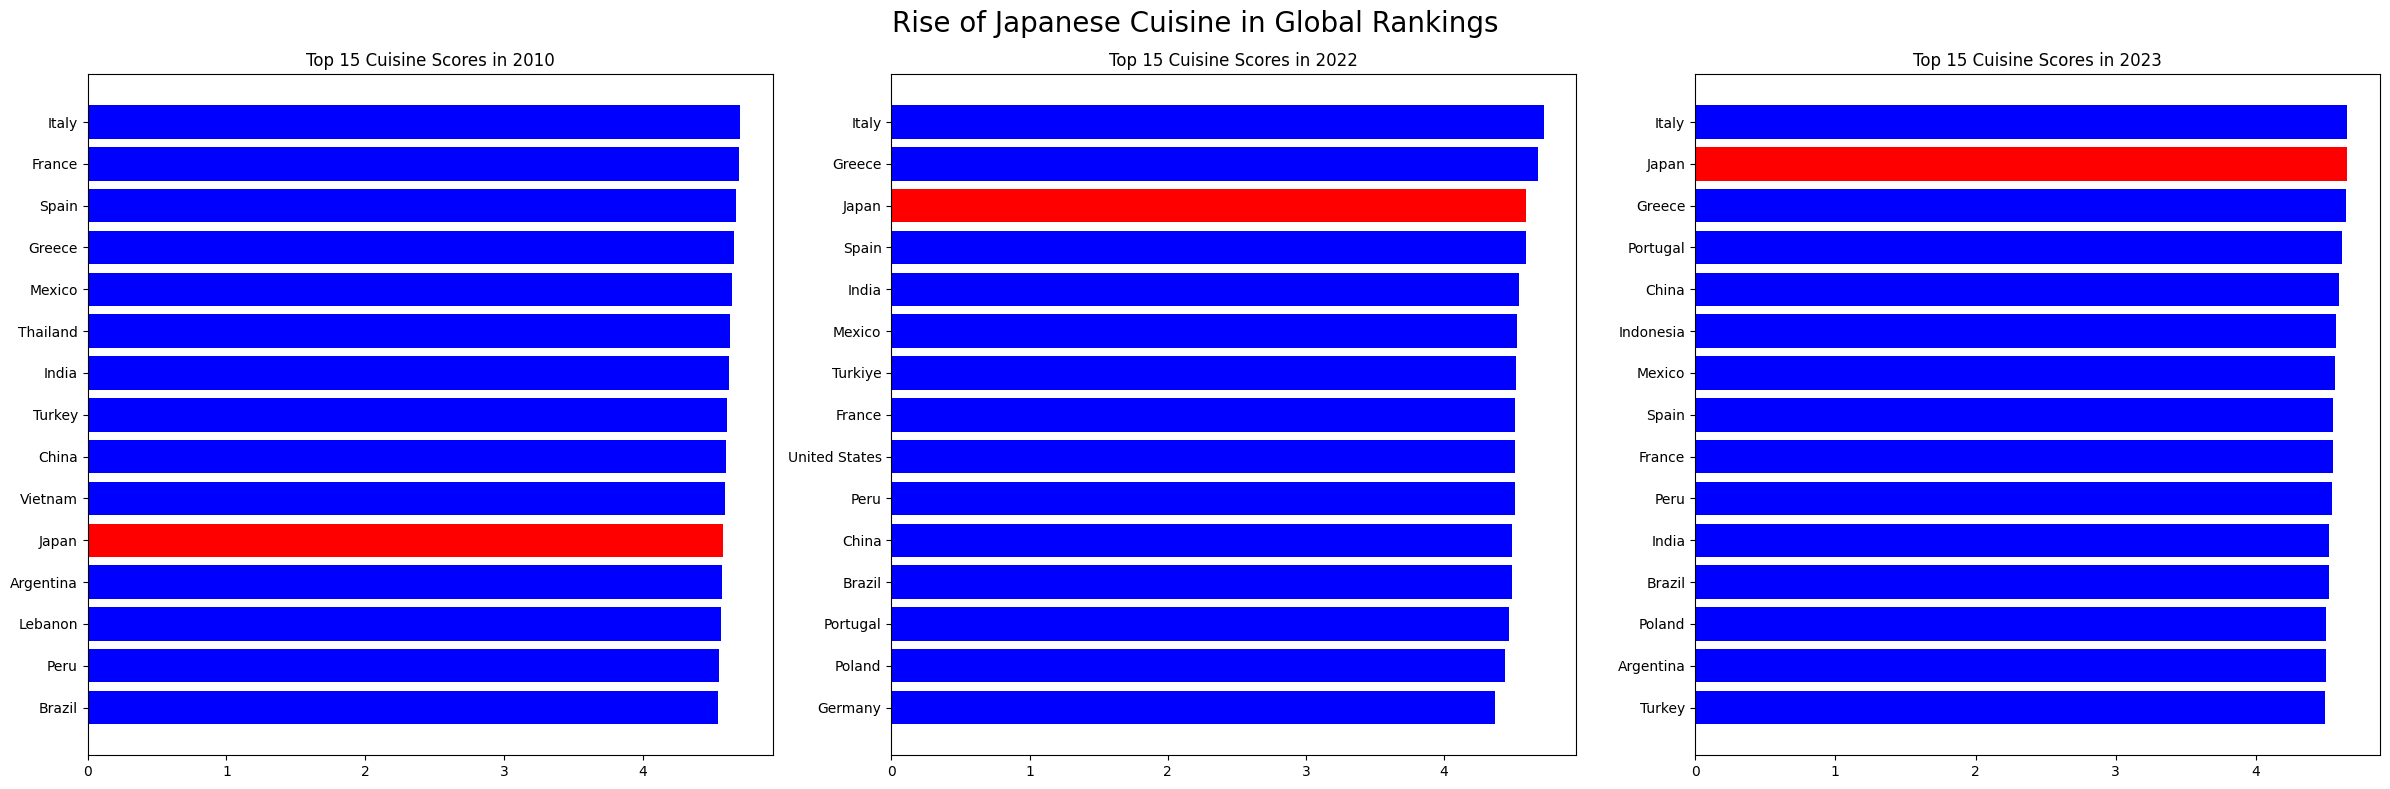

In [ ]:
# Graph 18 : Rise of Japanese Cuisine in Global Rankings

# Divide the dataframe by year
cuisines_2010 = cuisines_df[cuisines_df['Year'] == 2010].sort_values('Score', ascending=False).head(15)
cuisines_2022 = cuisines_df[cuisines_df['Year'] == 2022].sort_values('Score', ascending=False).head(15)
cuisines_2023 = cuisines_df[cuisines_df['Year'] == 2023].sort_values('Score', ascending=False).head(15)

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

def plot_hbar(ax, df, title, color_cuisine='Japan'):
    colors = ['red' if cuisine == color_cuisine else 'blue' for cuisine in df['Cuisine']]
    ax.barh(df['Cuisine'], df['Score'], color=colors)
    ax.set_title(title)
    ax.invert_yaxis()

plot_hbar(axes[0], cuisines_2010, 'Top 15 Cuisine Scores in 2010')
plot_hbar(axes[1], cuisines_2022, 'Top 15 Cuisine Scores in 2022')
plot_hbar(axes[2], cuisines_2023, 'Top 15 Cuisine Scores in 2023')

fig.suptitle("Rise of Japanese Cuisine in Global Rankings", fontsize=20)

plt.tight_layout()
plt.show()


### Public opinion
<a id="public_opinion"></a>
  
  Public opinion data was gathered through an automated scraping process using a [specially developed tool](https://browserflow.app) designed to simulate the copy-paste method. This tool was configured to efficiently capture the desired data and place it directly into a preset spreadsheet, facilitating subsequent analysis. Specifically, user comments were extracted from a wide range of social media platforms and online forums, including Instagram, YouTube, Reddit, Facebook, Quora, Twitter, and Tripadvisor. Each platform was carefully analyzed to ensure that the comments collected were relevant and representative of public opinions on specific topics. Once the data collection was completed, all the information was then organized, consolidated and gathered into a single file named `comments.csv`. It is possible to see this file imported in the cell below.
  
  [_click here to get back to the top_](#intro)

In [3]:
fname_comm = "comments.csv"

In [16]:
comments_df = pd.read_csv(os.path.join(data_folder,comment_folder,fname_comm), header=0)

In [17]:
colour_sources={"Instagram":"#FF2084",
         "YouTube":"#FF0000",
         "Reddit":"#FF3600", 
         "Facebook":"#006EFF",
         "Quora":"#A80000",
         "Twitter":"#08003B",
         "Tripadvisor":"#00C081"}

In [18]:
# Graph 19 : Data per Source
source_counts = comments_df['Source'].value_counts()
colors = [colour_sources[source] if source in colour_sources else '#333333' for source in source_counts.index] 

fig = go.Figure(go.Bar(x=source_counts.index,
    y=source_counts.values,
    marker_color=colors))

fig.update_layout(title='Data per Source',
    xaxis_title='Source',
    yaxis_title='Count',
    template='plotly_white')

fig.show()

In [19]:
def detect_emoji(text):
    emoji_set = set()
    
    for character in text:
        if emoji.is_emoji(character):
            emoji_text = emoji.demojize(character, delimiters=("", " "))
            emoji_set.add(emoji_text)
    
    print(list(emoji_set))
    return list(emoji_set)

detect_emoji(comments_df["Comment"])

['cherry_blossom ', 'red_heart ', 'thumbs_up ', 'green_heart ', 'raising_hands ', 'star-struck ', 'victory_hand_light_skin_tone ', 'fire ', 'smiling_face_with_heart-eyes ', 'two_hearts ']


['cherry_blossom ',
 'red_heart ',
 'thumbs_up ',
 'green_heart ',
 'raising_hands ',
 'star-struck ',
 'victory_hand_light_skin_tone ',
 'fire ',
 'smiling_face_with_heart-eyes ',
 'two_hearts ']

In [20]:
emoji_adjustment={'green_heart ':"green heart",
 'raising_hands ': "raising hands",
 'cherry_blossom ': "cherry blossom",
 'red_heart ': "red heart",
 'fire ': "fire",
 'two_hearts ': "two hearts",
 'star-struck ': "excited",
 'thumbs_up ': "thumbs up",
 'victory_hand_light_skin_tone ': "victory hand",
 'smiling_face_with_heart-eyes ': "heart eyes"}

In [21]:
def demojize_comment(text):

    text = text.replace("'"," ") 
    #Demojize before tokenizing to preserve the integrity of compound emojis
    text = emoji.demojize(text, delimiters=(" ", " "))

    tokens = text.split()
    processed_tokens = []
    
    for token in tokens:
        if token in emoji_adjustment:
            processed_tokens.append(emoji_adjustment[token]) #Using the dictionary identified before
        else:
            processed_tokens.append(token)
    
    #Reconstruct the text from processed tokens
    text = ' '.join(processed_tokens)
    text = text.lower()

    return text

comments_df["Cleaned comment"] = comments_df["Comment"].apply(demojize_comment)

In [28]:
#Initialize the language detector
language_detector = pipeline('text-classification', model='papluca/xlm-roberta-base-language-detection')

auth_key = "3ecb5e5e-503e-4e88-b704-45a798ca2217:fx" #"1ee03999-5d36-4f8d-8649-a65d00fba3a2:fx" è mia
translator = deepl.Translator(auth_key)

In [23]:
#This function detects the language of the input text using the language detector pipeline
def detect_language(text):
    if not text.strip():
        return "undefined"
    try:
        text = text[:512] #This limit is specified in order to avoid exceding the model input size
        lang = language_detector(text)[0]['label']
        return lang
    except Exception as e:
        print(f"Error while detecting language: {e}")
        return ""
        
language = comments_df['Cleaned comment'].apply(detect_language)
comments_df.insert(3, "Language", language)

,Comment,Source,Cleaned comment,Language
5982,Wow! I just found this video in my recommendat...,YouTube,wow! i just found this video in my recommendat...,en
4259,川向こうの駐車場に止めて川を渡り合掌造り集落に入って行きました。\n入場料とかは入りませんが...,Tripadvisor,川向こうの駐車場に止めて川を渡り合掌造り集落に入って行きました。 入場料とかは入りませんが車...,ja
4816,外国人の友達と一緒の来場でした。私は何年振りかのランドでしたが夏休み前の平日という事もあり混...,Tripadvisor,外国人の友達と一緒の来場でした。私は何年振りかのランドでしたが夏休み前の平日という事もあり混...,ja
457,"Le escursioni notturne sul Monte Fuji, con la ...",Facebook,"le escursioni notturne sul monte fuji, con la ...",it
1170,Wow amazing,Instagram,wow amazing,en


In [25]:
# Graph 20 : Data per Language
source_counts = comments_df["Language"].value_counts()

fig = go.Figure(go.Bar(x=source_counts.index,
    y=source_counts.values,))

fig.update_layout(title='Data per Language',
    xaxis_title='Language',
    yaxis_title='Count',
    template='plotly_white')

fig.show()

The Deepl API provides a text translation service with a character limit. If a translation request exceeds this limit, it may not fully translate all comments and could result in error messages being displayed

In [ ]:
#Creating a function to translate the non-English input text in English
def translate_text(text, lang):

    if lang != 'en':
        try:

            segments = [text[i:i+500] for i in range(0, len(text), 500)] #To fit the DeepL API limits
            translated_segments = [translator.translate_text(segment, target_lang='EN-US').text for segment in segments]
            return ' '.join(translated_segments)
        except Exception as e:
            print(f"Error while translating text: {e}")
            return text
    else:
        return text

comments_df["Translated comment"] = comments_df.apply(lambda row: translate_text(row['Cleaned comment'], row['Language']), axis=1)

In [39]:
# We save the dataframe in a csv file because the process of detecting and translating comments is time consuming
fname_comm2="comments_translated.csv"
# comments_df.to_csv(os.path.join(data_folder,comment_folder,fname_comm2),index=False) 

In [55]:
# CONTEXT SENSITIVE SENTIMENT ANALYSIS
comments_df=pd.read_csv(os.path.join(data_folder,comment_folder,fname_comm2), header=0)
comments_df=comments_df[comments_df["Translated comment"].notnull()]

In [56]:
#Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [57]:
#This function is used to 
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    class_names = ['negative', 'positive']
    predicted_class = class_names[predictions.argmax()]
    probabilities = predictions.numpy().flatten()
    probability_dict = {class_names[i]: probabilities[i] for i in range(len(class_names))}

    return predicted_class, probability_dict

In [58]:
comments_df['Sentiment'] = comments_df["Translated comment"].apply(predict_sentiment)

In [60]:
fname_comm3="comments_with_sentiment.csv"
# If needed, save the dataframe in a csv file
# comments_df.to_csv(os.path.join(data_folder,comment_folder,fname_comm3),index=False) 

In [87]:
comments_df["Sentiment"][0]

"('negative', {'negative': 0.98576665, 'positive': 0.014233306})"

In [84]:
nltk.download('stopwords') # download stopwords from nltk library
stopwords = set(stopwords.words('english')) # setup stopwords on english language
stopwords.update(["one", "go"]) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package punkt to /Users/simone/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


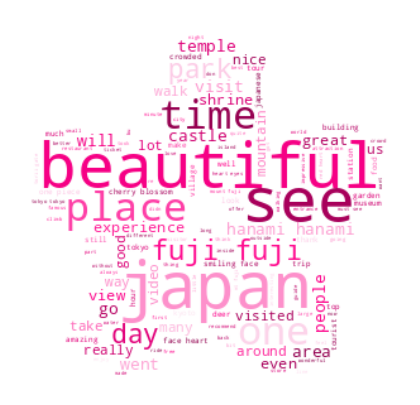

In [85]:
# Graph 21 : Opinion Wordcloud

nltk.download('punkt')

cloud_mask = np.array(Image.open('/Users/simone/Desktop/Luiss /*Data Visualization/*Final Project 3/Data/Comments/cherryflower.jpg')) #cloud mask is an image of a black cloud on white background used to give the shape to the wordcloud
all_text = ' '.join(comments_df['Translated comment'])

all_text = all_text.lower()
all_text = re.sub(r'\b\w\b\s*', '', all_text)
all_text = re.sub(r'\s+', ' ', all_text).strip()

# Text tokenization
tokens = word_tokenize(all_text)

# Stopwords filtering
stopwords = set(STOPWORDS)
filtered_tokens = [word for word in tokens if word not in stopwords]

# Concatenation of tokens
filtered_text = ' '.join(filtered_tokens)

colors = LinearSegmentedColormap.from_list("custom_pink_scale", [(0, "#FCE4F1"), (0.5, "#FF008A"), (1, "#8C004C")])

# Wordcloud creation
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords,
                      max_words=500, mask=cloud_mask, contour_width=0,
                      colormap=colors).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [105]:
def extract_sentiment(sentiment_str):
    sentiment_str = sentiment_str.strip("'")
    parts = sentiment_str.split(", ", 1)
    
    sentiment_dict_str = parts[1].strip("{} ")
    sentiment_items = sentiment_dict_str.split(", ")
    sentiment_dict = {}
    
    for item in sentiment_items:
        key, value = item.split(": ")
        key = key.strip("'")
        value = float(value.strip(")}"))  
        sentiment_dict[key] = value

    predominant_sentiment = max(sentiment_dict, key=sentiment_dict.get)
    return predominant_sentiment

comments_df['Main Sentiment'] = comments_df['Sentiment'].apply(extract_sentiment)

In [106]:
# Graph 22 : Sentiment Distribution per Source

sentiment_count = comments_df.groupby(['Source', 'Main Sentiment']).size().reset_index(name='Count')
total_count = comments_df.groupby('Source').size().reset_index(name='Total Count')
total_count = total_count.sort_values(by='Total Count', ascending=False)

sentiment_count['Source'] = pd.Categorical(sentiment_count['Source'], categories=total_count['Source'], ordered=True)
sentiment_count = sentiment_count.sort_values(by='Source')

fig = go.Figure()
for sentiment in sentiment_count['Main Sentiment'].unique():
    filtered_df = sentiment_count[sentiment_count['Main Sentiment'] == sentiment]
    fig.add_trace(go.Bar(x=filtered_df['Source'],
        y=filtered_df['Count'],
        name=f"{sentiment.capitalize()}",
        marker_color={'negative': '#FE4444', 'positive': '#32BE4C'}[sentiment]))

fig.add_trace(go.Bar(x=total_count['Source'],
    y=total_count['Total Count'],
    name='Total',
    marker_color='#636EFA',
    opacity=0.5))

fig.update_layout(barmode='group',
    title='Sentiment Distribution per Source',
    xaxis_title='Source',
    yaxis_title='Count',
    legend_title='Sentiment',
    yaxis=dict(showgrid=True),
    xaxis=dict(showgrid=False),
    xaxis_categoryorder='total descending')

fig.show()
